## CREDIT CARD FRAUD

## 1.0 EDA

Firstly we need to import the necessary libraries and configure the Spark session. After that, we load our data set, in order to analyse it, and perform EDA.

In [1]:
#Import libraries and configure spark session
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
from scipy import stats
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

import pyspark.sql.functions as f
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("xpto") \
    .getOrCreate()
sc = spark.sparkContext

In [2]:
# Load file
df = spark.read.csv('creditcard.csv', header=True, inferSchema=True, sep=",")

# Print Schema
df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

It appears that the dataset has a total of 31 columns, in which 28 of them are components that are results of PCA. Columns V1-V28 are going to be more abstract, since we don't have a clear definition/description of what they represent.

In [3]:
df.head()

Row(Time=0.0, V1=-1.3598071336738, V2=-0.0727811733098497, V3=2.53634673796914, V4=1.37815522427443, V5=-0.338320769942518, V6=0.462387777762292, V7=0.239598554061257, V8=0.0986979012610507, V9=0.363786969611213, V10=0.0907941719789316, V11=-0.551599533260813, V12=-0.617800855762348, V13=-0.991389847235408, V14=-0.311169353699879, V15=1.46817697209427, V16=-0.470400525259478, V17=0.207971241929242, V18=0.0257905801985591, V19=0.403992960255733, V20=0.251412098239705, V21=-0.018306777944153, V22=0.277837575558899, V23=-0.110473910188767, V24=0.0669280749146731, V25=0.128539358273528, V26=-0.189114843888824, V27=0.133558376740387, V28=-0.0210530534538215, Amount=149.62, Class=0)

In [4]:
#Shape of the Dataframe
print((df.count(), len(df.columns)))

(284807, 31)


After performing the counts above, we conclude that we are going to be working with a dataset that has 284 807 rows.

In [5]:
df.toPandas().info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
df.toPandas().head(5)

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [7]:
#statistics
df.toPandas().describe().T

count          mean           std         min           25%  \
Time    284807.0  9.481386e+04  47488.145955    0.000000  54201.500000   
V1      284807.0  1.168375e-15      1.958696  -56.407510     -0.920373   
V2      284807.0  3.416908e-16      1.651309  -72.715728     -0.598550   
V3      284807.0 -1.379537e-15      1.516255  -48.325589     -0.890365   
V4      284807.0  2.074095e-15      1.415869   -5.683171     -0.848640   
V5      284807.0  9.604066e-16      1.380247 -113.743307     -0.691597   
V6      284807.0  1.487313e-15      1.332271  -26.160506     -0.768296   
V7      284807.0 -5.556467e-16      1.237094  -43.557242     -0.554076   
V8      284807.0  1.205498e-16      1.194353  -73.216718     -0.208630   
V9      284807.0 -2.406306e-15      1.098632  -13.434066     -0.643098   
V10     284807.0  2.238853e-15      1.088850  -24.588262     -0.535426   
V11     284807.0  1.673327e-15      1.020713   -4.797473     -0.762494   
V12     284807.0 -1.247012e-15      0.999201  -18.683715     -0.405571   
V13     284807.0  8.190001e-16      0.995274   -5.791881     -0.648539   
V14     284807.0  1.207294e-15      0.958596  -19.214325     -0.425574   
V15     284807.0  4.887456e-15      0.915316   -4.498945     -0.582884   
V16     284807.0  1.437516e-15      0.876253  -14.129855     -0.468037   
V17     284807.0 -3.740237e-16      0.849337  -25.162799     -0.483748   
V18     284807.0  9.564149e-16      0.838176   -9.498746     -0.498850   
V19     284807.0  1.039917e-15      0.814041   -7.213527     -0.456299   
V20     284807.0  6.407202e-16      0.770925  -54.497720     -0.211721   
V21     284807.0  1.656562e-16      0.734524  -34.830382     -0.228395   
V22     284807.0 -3.568593e-16      0.725702  -10.933144     -0.542350   
V23     284807.0  2.610582e-16      0.624460  -44.807735     -0.161846   
V24     284807.0  4.473066e-15      0.605647   -2.836627     -0.354586   
V25     284807.0  5.213180e-16      0.521278  -10.295397     -0.317145   
V26     284807.0  1.683537e-15      0.482227   -2.604551     -0.326984   
V27     284807.0 -3.659966e-16      0.403632  -22.565679     -0.070840   
V28     284807.0 -1.223710e-16      0.330083  -15.430084     -0.052960   
Amount  284807.0  8.834962e+01    250.120109    0.000000      5.600000   
Class   284807.0  1.727486e-03      0.041527    0.000000      0.000000   

                 50%            75%            max  
Time    84692.000000  139320.500000  172792.000000  
V1          0.018109       1.315642       2.454930  
V2          0.065486       0.803724      22.057729  
V3          0.179846       1.027196       9.382558  
V4         -0.019847       0.743341      16.875344  
V5         -0.054336       0.611926      34.801666  
V6         -0.274187       0.398565      73.301626  
V7          0.040103       0.570436     120.589494  
V8          0.022358       0.327346      20.007208  
V9         -0.051429       0.597139      15.594995  
V10        -0.092917       0.453923      23.745136  
V11        -0.032757       0.739593      12.018913  
V12         0.140033       0.618238       7.848392  
V13        -0.013568       0.662505       7.126883  
V14         0.050601       0.493150      10.526766  
V15         0.048072       0.648821       8.877742  
V16         0.066413       0.523296      17.315112  
V17        -0.065676       0.399675       9.253526  
V18        -0.003636       0.500807       5.041069  
V19         0.003735       0.458949       5.591971  
V20        -0.062481       0.133041      39.420904  
V21        -0.029450       0.186377      27.202839  
V22         0.006782       0.528554      10.503090  
V23        -0.011193       0.147642      22.528412  
V24         0.040976       0.439527       4.584549  
V25         0.016594       0.350716       7.519589  
V26        -0.052139       0.240952       3.517346  
V27         0.001342       0.091045      31.612198  
V28         0.011244       0.078280      33.847808  
Amount     22.000000      77.165000   25691.160000  

The maximum amount of time (in seconds) recorded between transactions is 172792 seconds, which is equivalent to 2880 minutes, or approx. 48 hours. We can also conclude that the maximum value for Amount is $ 25691.16.

## 1.1 CHECKING MISSING VALUES

In [8]:
#Check missing and null data
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



Above checked for missing values. Each column shows the amount of null or NaN values in each column. It appears that the dataset doesn't have missing values!

## HOW MANY ROWS IN THE DATASET REPRESENT CREDIT CARD FRAUD?

In [9]:
#Number of Frauds and non-frauds
classFreq = df.groupBy("Class").count()
classFreq.show()

+-----+------+
|Class| count|
+-----+------+
|    1|   492|
|    0|284315|
+-----+------+



In [10]:
total = classFreq.select("count").agg({"count": "sum"}).collect().pop()['sum(count)']
result = classFreq.withColumn('percent', (classFreq['count']/total) * 100)
result.show()

+-----+------+------------------+
|Class| count|           percent|
+-----+------+------------------+
|    1|   492|0.1727485630620034|
|    0|284315| 99.82725143693798|
+-----+------+------------------+



Here we can see that, out of the 284 807 rows of information available, 492 represent credit card fraud, which translates to approx. 17% of the records. With these results, it is safe to say that we have an unbalanced dataset.

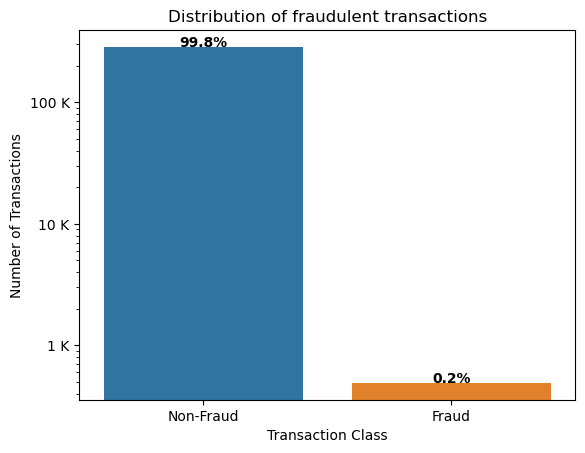

In [11]:
fraud_df = df.select("Class").toPandas()

# Count the number of transactions for each class (fraudulent or not)
fraud_counts = fraud_df['Class'].value_counts()

# Calculate the percentage of each class
fraud_perc = fraud_counts / fraud_counts.sum() * 100

# Create a bar plot with logarithmic y-axis
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.yscale('log')

# Add percentage labels to the bars
for i, v in enumerate(fraud_counts):
    plt.text(i, v, f"{fraud_perc[i]:.1f}%", ha='center', fontweight='bold')

# Set the y-axis labels and formatter
plt.ylabel('Number of Transactions')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f} K'.format(x/1000)))

# Set the axis labels and title
plt.xlabel('Transaction Class')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.title('Distribution of fraudulent transactions')

plt.show()

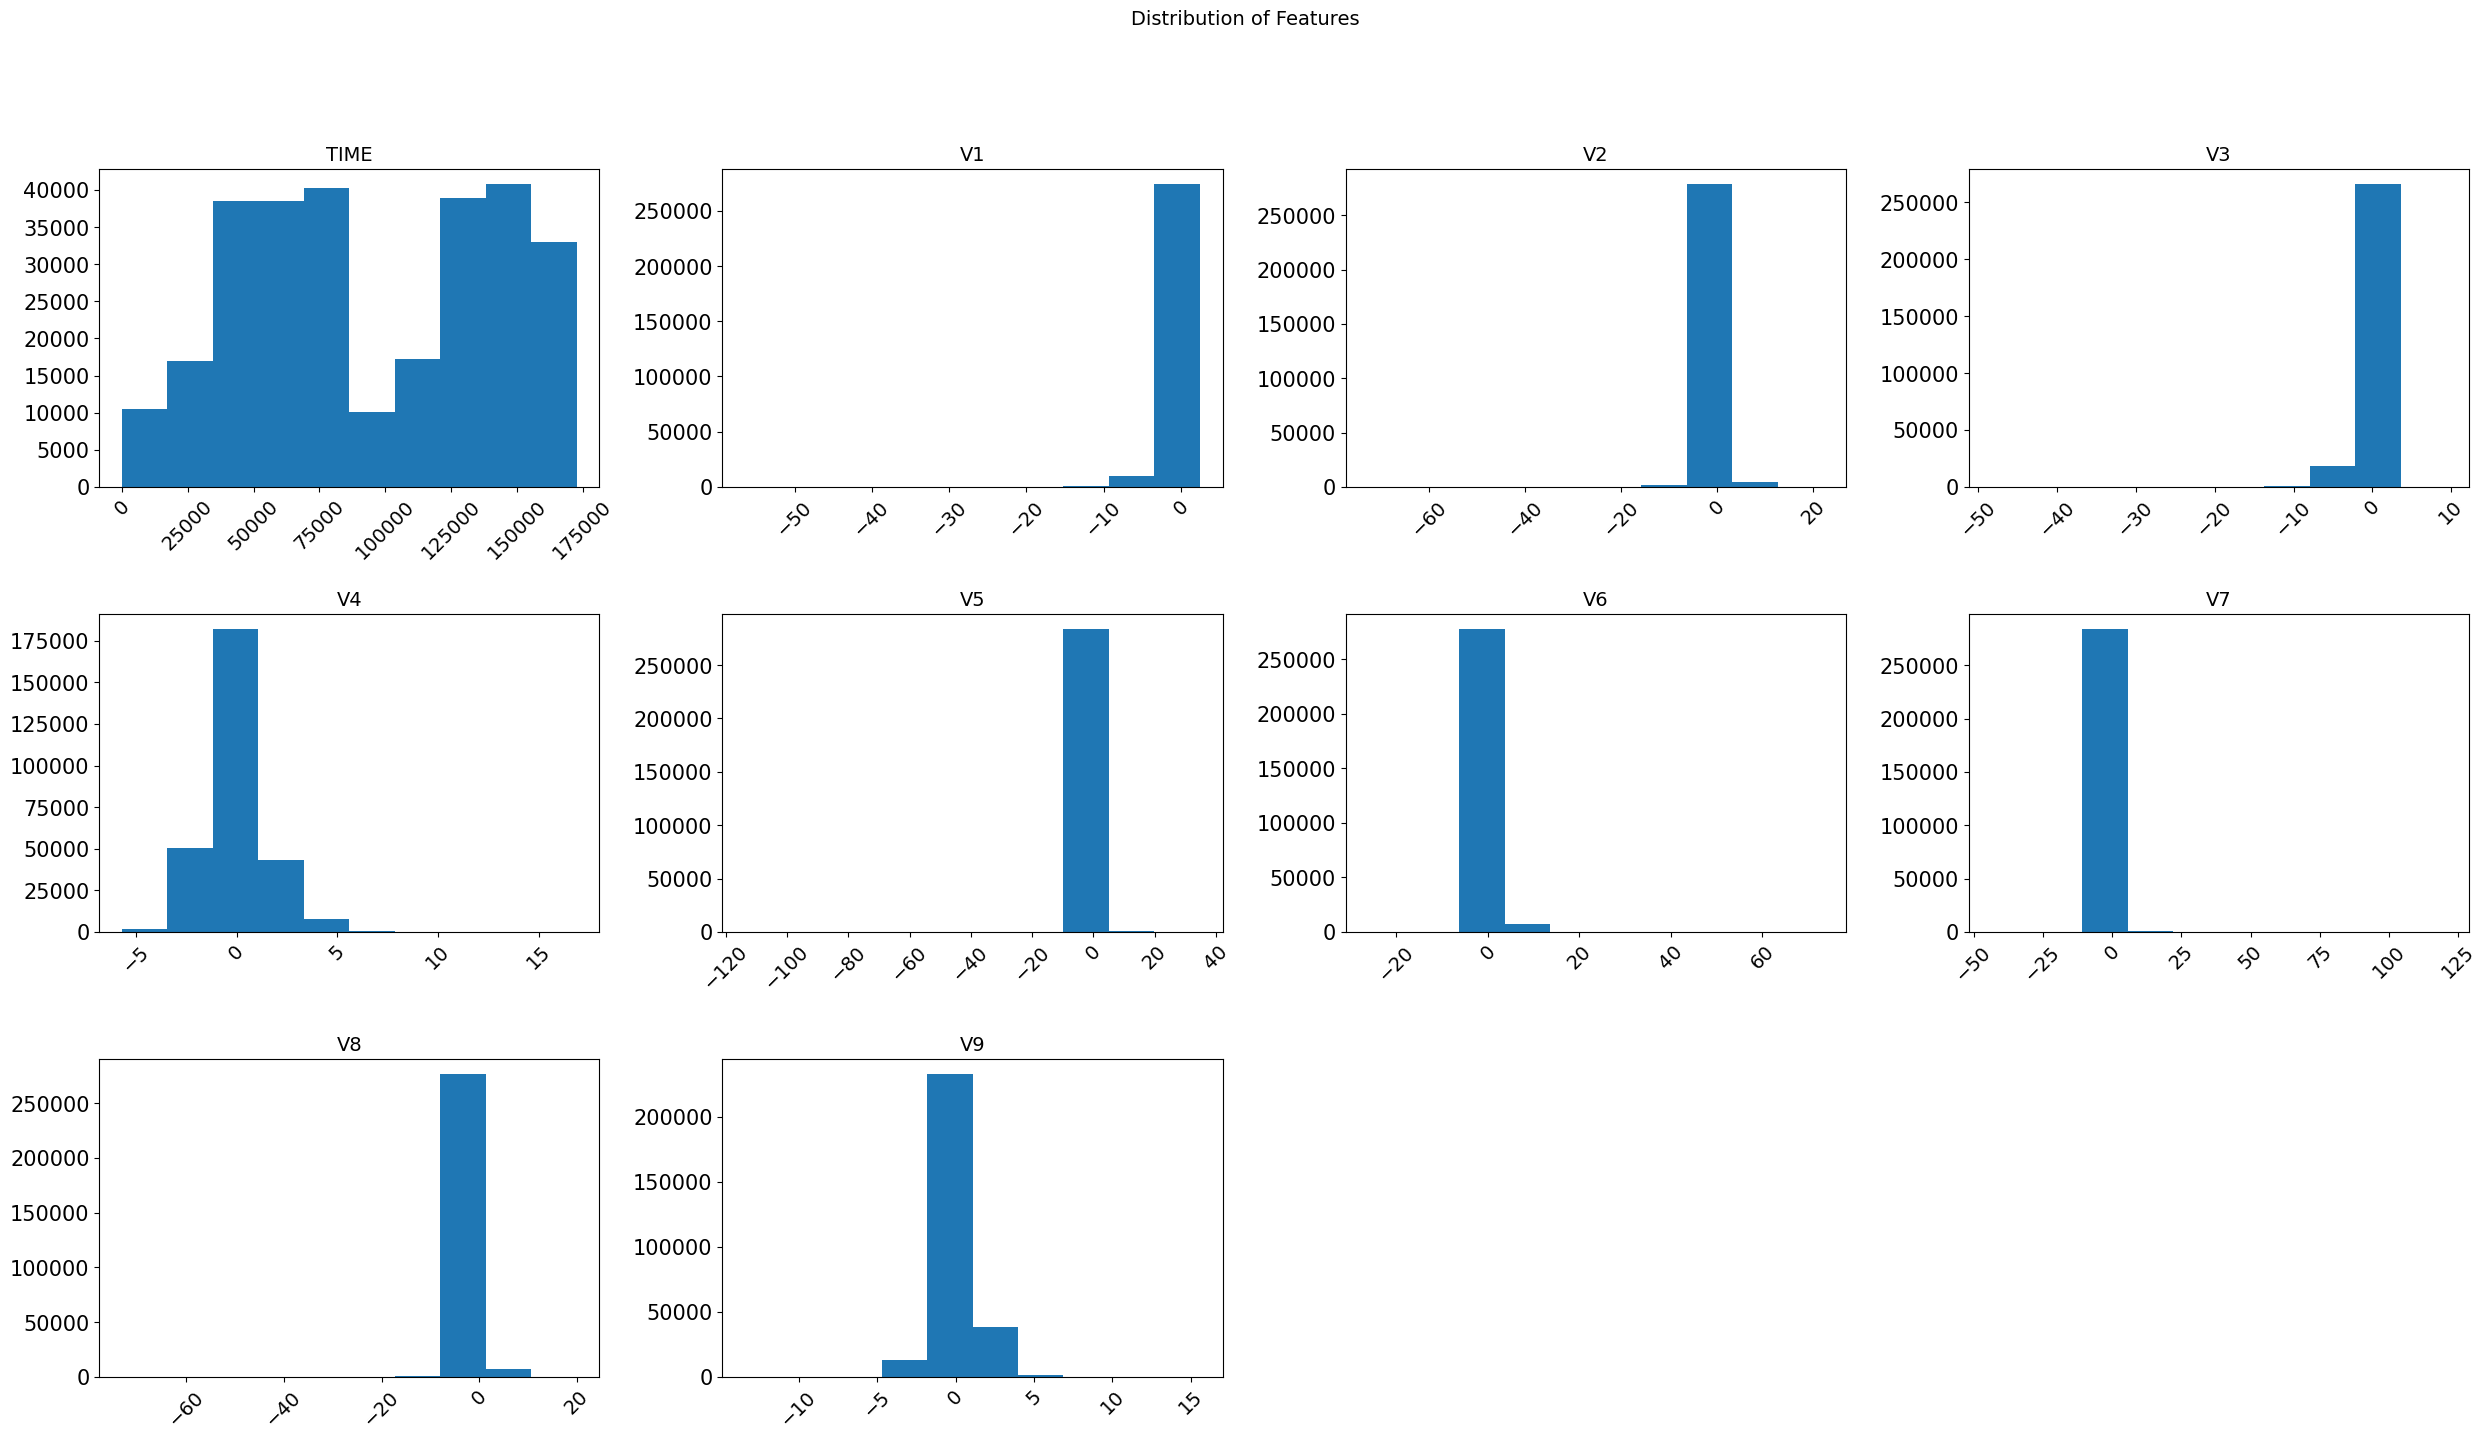

In [12]:
# create several histograms to show the distributions of the features
fig = plt.figure(figsize=(25, 15))
subtitle = fig.suptitle("Distribution of Features", fontsize=14, verticalalignment="center")
for col, num in zip(df.toPandas().describe().columns, range(1, 11)):
    ax = fig.add_subplot(3, 4, num)
    ax.hist(df.toPandas()[col])
    plt.grid(False)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=15)
    plt.title(col.upper(), fontsize=14)
plt.tight_layout()
subtitle.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

By analysing these plots, we conclude that Time does not have a normal distribution and the values 75 000-100 000 seconds are the ones with less occurences throughout the dataset. All of the Vx componentes are normalized, and with most occurences centered around the value 0. These feautures also show some negative values.

## USER DEFINED FUCTIONS

Firstly lets create YES or NO values to assign to the values in our "Class" column. If the values is 1, then we assign it a "yes", and if the value is 0, then we assign it a "no". After developing the function, we also create a column called "IsFraud".

In [13]:
# create the yes/no function
y_udf = f.udf(lambda y: "no" if y == 0 else "yes", f.StringType())

In [14]:
# create the new column for the yes/no values
df = df.withColumn("IsFraud", y_udf('Class'))

df.show(5)

+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+-------+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                 V21|                V

In [15]:
# create a function to group time values
def udf_multi(time):
    if(time < 50000):
        return "Under 50K s"
    elif(time >= 50000 and time <= 100000):
        return "Between 50K and 100K s"
    elif(time > 100000):
        return "Over 100K s"
    else: return "NA"

In [16]:
# apply the function to the "Time column"
time_udf = f.udf(udf_multi)
df = df.withColumn('time_udf', time_udf('Time'))

df.show(5)

+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+-------+-----------+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                 V21|     

APPLYING SOME STATISTICS

In [17]:
from pyspark.sql import Window 
window = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing) 

In [18]:
# lets create a table
time_group_table = df.select(["time_udf", "Amount"]).\
                         groupBy('time_udf').\
                            agg(
                                f.count("Amount").alias("UserCount"),
                                f.mean("Amount").alias("Amount_Avg"),
                                f.min("Amount").alias("Amount_Min"),
                                f.max("Amount").alias("Amount_Max")).\
                            withColumn("total", f.sum(f.col("UserCount")).over(window)).\
                            withColumn("Percent", f.col("UserCount")*100 / f.col("total")).\
                            drop(f.col("total")).sort(f.desc("Percent"))

In [19]:
time_group_table.toPandas()

time_udf  UserCount  Amount_Avg  Amount_Min  Amount_Max  \
0             Over 100K s     131048   88.129787         0.0    25691.16   
1  Between 50K and 100K s      91944   83.859063         0.0    18910.00   
2             Under 50K s      61815   95.494943         0.0    19656.53   

     Percent  
0  46.012914  
1  32.282914  
2  21.704172

Here we computed some statistics with the "Amount" column, divided by the three time groups defined earlier. Now let's plot our results:

<Axes: xlabel='time_udf', ylabel='Percent'>

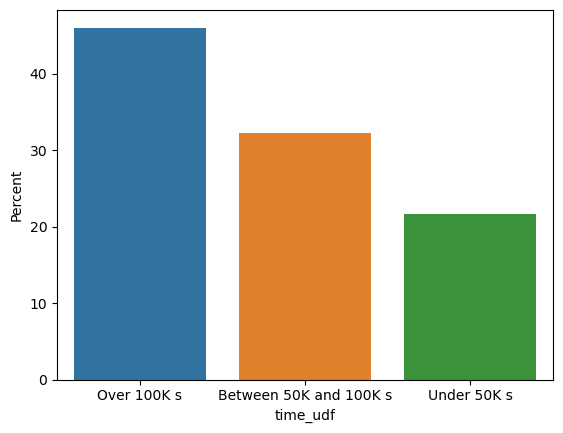

In [20]:
sns.barplot(x="time_udf", y="Percent", data=time_group_table.toPandas())

After analysing the graph, we conclude that the largest percentage for the Amount values is found when the time between each transaction recorded is over 100 000 seconds.

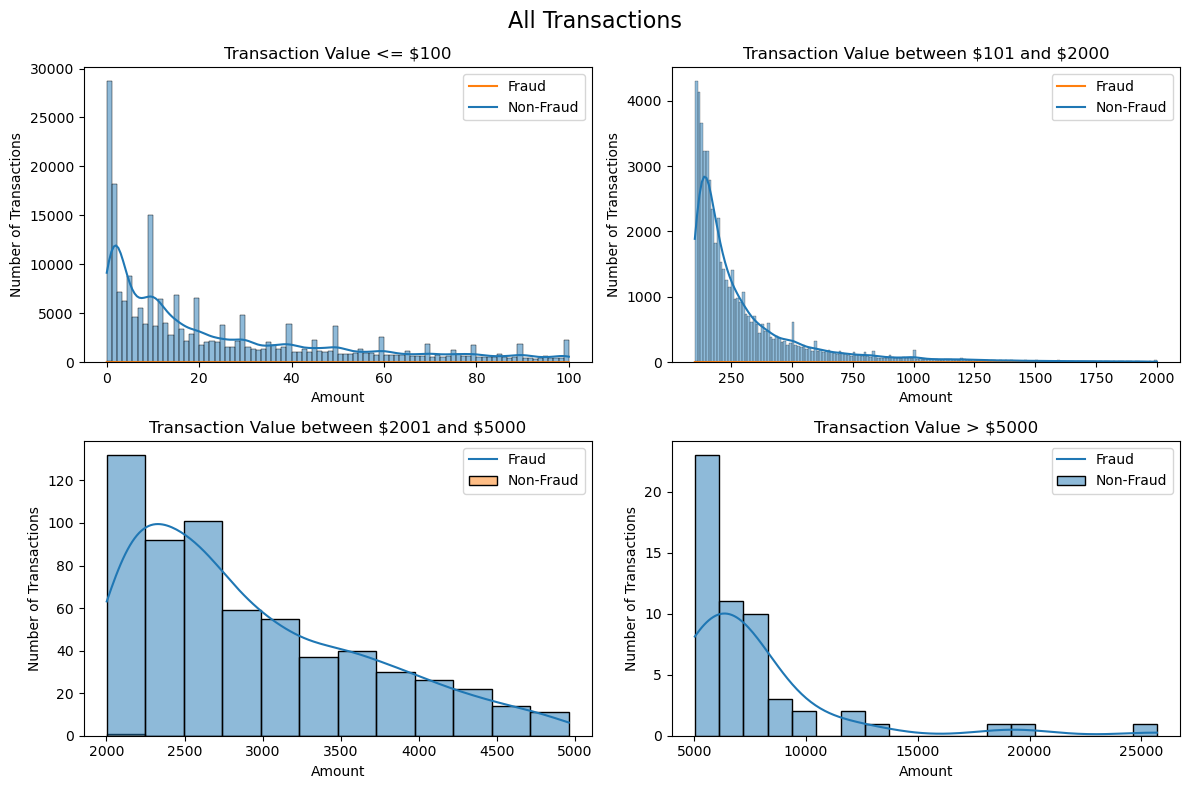

In [21]:
# All Transactions
df_aux = df.select("Class", "Amount").toPandas()

# Define amount ranges
amount_ranges = [
    {"range": "Transaction Value <= $100", "min_amount": 0, "max_amount": 100},
    {"range": "Transaction Value between \$101 and \$2000", "min_amount": 101, "max_amount": 2000},
    {"range": "Transaction Value between \$2001 and \$5000", "min_amount": 2001, "max_amount": 5000},
    {"range": "Transaction Value > $5000", "min_amount": 5001, "max_amount": df_aux["Amount"].max()}
]

# Create four subplots for different amount ranges
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for idx, amount_range in enumerate(amount_ranges):
    row_idx = idx // 2
    col_idx = idx % 2

    # Filter transactions within amount range
    df_range = df_aux[(df_aux["Amount"] > amount_range["min_amount"]) & (df_aux["Amount"] <= amount_range["max_amount"])]

    # Plot histogram
    sns.histplot(data=df_range, x="Amount", ax=axes[row_idx, col_idx], hue="Class", kde=True)
    axes[row_idx, col_idx].set_title(amount_range["range"])
    axes[row_idx, col_idx].set_ylabel("Number of Transactions")
    axes[row_idx, col_idx].legend(labels=["Fraud", "Non-Fraud"])

fig.suptitle("All Transactions", fontsize=16)
plt.tight_layout()
plt.show()

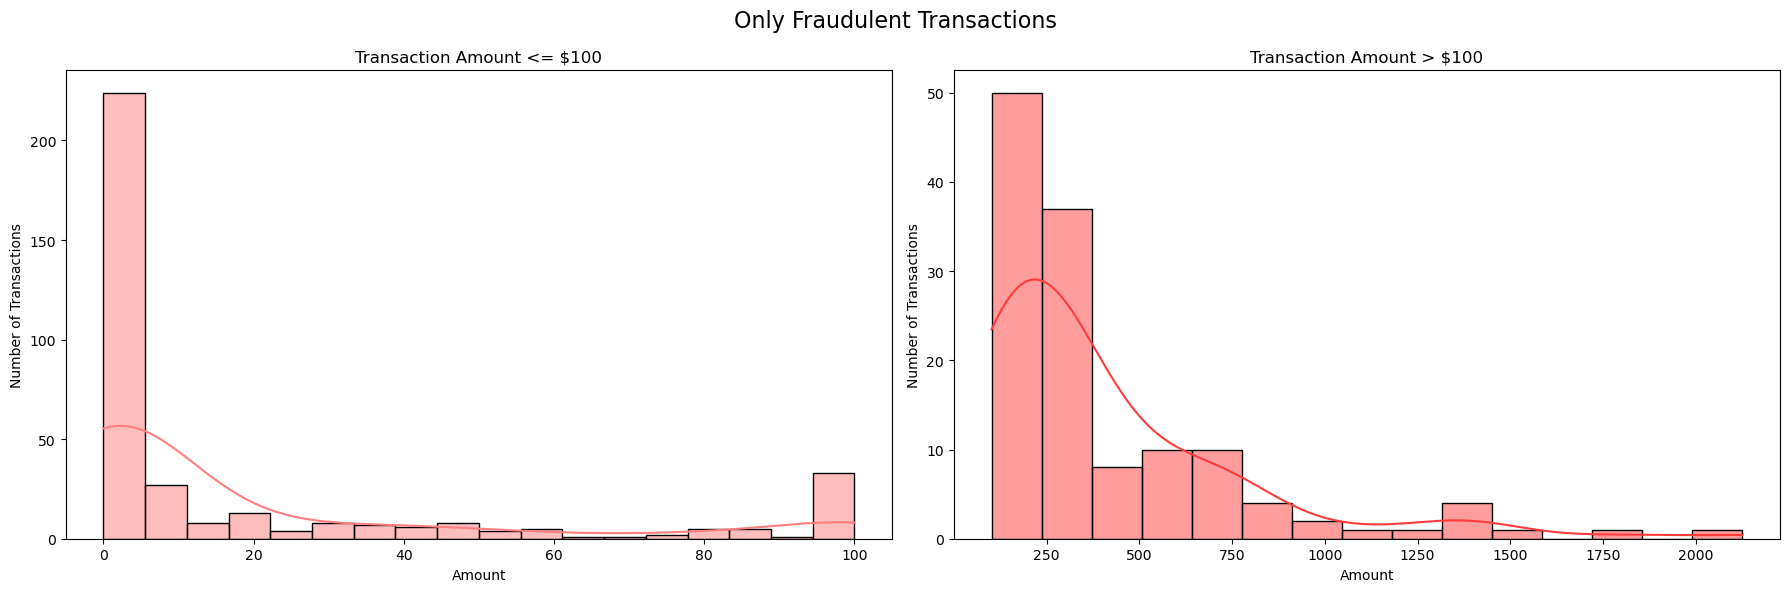

In [22]:
# Only fraud transactions
only_fraud = df.filter(df.Class == 1).select("Amount").toPandas()

# Add a pallet
aux_pal = ["#ff7f7f", "#ff3c3c"]

# Create three subplots for different amount ranges
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Amount range <= 100
sns.histplot(data=only_fraud[only_fraud["Amount"] <= 100], x="Amount", ax=axes[0], kde=True, color=aux_pal[0])
axes[0].set_title("Transaction Amount <= $100")
axes[0].set_ylabel("Number of Transactions")

# Amount range > 100
sns.histplot(data=only_fraud[(only_fraud["Amount"] > 100)], x="Amount", ax=axes[1], kde=True, color=aux_pal[1])
axes[1].set_title("Transaction Amount > $100")
axes[1].set_ylabel("Number of Transactions")

fig.suptitle("Only Fraudulent Transactions", fontsize=16)
plt.tight_layout()
plt.show()

Now we move on and try to do some correlation:

In [23]:

# create a dataframe with only numeric features in order to simplify our correlactions
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
numeric_features_df = df.select(numeric_features)
numeric_features_df.toPandas().head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [24]:
col_names = numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])

In [25]:
# import Statistics from mllib -> Pyspark and import Pandas
from pyspark.mllib.stat import Statistics
import pandas as pd

In [26]:
# create a correlation matrix
corr_matrix = Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_matrix)
corr_df.index = col_names
corr_df.columns = col_names
round(corr_df, 2)

Time    V1    V2    V3    V4    V5    V6    V7    V8    V9  ...   V21  \
Time    1.00  0.12 -0.01 -0.42 -0.11  0.17 -0.06  0.08 -0.04 -0.01  ...  0.04   
V1      0.12  1.00 -0.00 -0.00  0.00 -0.00  0.00  0.00 -0.00  0.00  ... -0.00   
V2     -0.01 -0.00  1.00  0.00 -0.00 -0.00  0.00  0.00 -0.00 -0.00  ...  0.00   
V3     -0.42 -0.00  0.00  1.00 -0.00 -0.00  0.00  0.00  0.00 -0.00  ... -0.00   
V4     -0.11  0.00 -0.00 -0.00  1.00 -0.00 -0.00  0.00  0.00  0.00  ... -0.00   
V5      0.17 -0.00 -0.00 -0.00 -0.00  1.00  0.00 -0.00  0.00  0.00  ... -0.00   
V6     -0.06  0.00  0.00  0.00 -0.00  0.00  1.00  0.00 -0.00  0.00  ... -0.00   
V7      0.08  0.00  0.00  0.00  0.00 -0.00  0.00  1.00 -0.00  0.00  ...  0.00   
V8     -0.04 -0.00 -0.00  0.00  0.00  0.00 -0.00 -0.00  1.00  0.00  ... -0.00   
V9     -0.01  0.00 -0.00 -0.00  0.00  0.00  0.00  0.00  0.00  1.00  ...  0.00   
V10     0.03  0.00 -0.00  0.00  0.00 -0.00  0.00  0.00  0.00 -0.00  ...  0.00   
V11    -0.25  0.00  0.00 -0.00 -0.00  0.00  0.00 -0.00  0.00  0.00  ... -0.00   
V12     0.12  0.00 -0.00  0.00 -0.00  0.00  0.00  0.00  0.00 -0.00  ...  0.00   
V13    -0.07 -0.00  0.00 -0.00 -0.00 -0.00 -0.00 -0.00 -0.00 -0.00  ...  0.00   
V14    -0.10  0.00 -0.00  0.00 -0.00 -0.00  0.00 -0.00 -0.00  0.00  ... -0.00   
V15    -0.18 -0.00  0.00  0.00 -0.00 -0.00  0.00  0.00  0.00 -0.00  ...  0.00   
V16     0.01  0.00  0.00  0.00 -0.00 -0.00 -0.00  0.00  0.00 -0.00  ... -0.00   
V17    -0.07 -0.00 -0.00 -0.00 -0.00  0.00  0.00  0.00 -0.00  0.00  ... -0.00   
V18     0.09  0.00  0.00  0.00  0.00  0.00  0.00 -0.00 -0.00  0.00  ... -0.00   
V19     0.03  0.00  0.00  0.00 -0.00 -0.00  0.00 -0.00 -0.00  0.00  ...  0.00   
V20    -0.05  0.00 -0.00 -0.00 -0.00 -0.00  0.00 -0.00 -0.00 -0.00  ... -0.00   
V21     0.04 -0.00  0.00 -0.00 -0.00 -0.00 -0.00  0.00 -0.00  0.00  ...  1.00   
V22     0.14  0.00  0.00  0.00  0.00  0.00 -0.00 -0.00  0.00  0.00  ...  0.00   
V23     0.05  0.00  0.00 -0.00  0.00  0.00 -0.00  0.00  0.00  0.00  ...  0.00   
V24    -0.02  0.00 -0.00 -0.00  0.00 -0.00 -0.00 -0.00 -0.00 -0.00  ...  0.00   
V25    -0.23 -0.00  0.00  0.00  0.00  0.00  0.00  0.00 -0.00  0.00  ... -0.00   
V26    -0.04 -0.00  0.00  0.00 -0.00  0.00 -0.00 -0.00 -0.00 -0.00  ... -0.00   
V27    -0.01  0.00 -0.00  0.00 -0.00  0.00 -0.00 -0.00  0.00 -0.00  ... -0.00   
V28    -0.01  0.00 -0.00  0.00 -0.00 -0.00  0.00  0.00 -0.00  0.00  ...  0.00   
Amount -0.01 -0.23 -0.53 -0.21  0.10 -0.39  0.22  0.40 -0.10 -0.04  ...  0.11   
Class  -0.01 -0.10  0.09 -0.19  0.13 -0.09 -0.04 -0.19  0.02 -0.10  ...  0.04   

         V22   V23   V24   V25   V26   V27   V28  Amount  Class  
Time    0.14  0.05 -0.02 -0.23 -0.04 -0.01 -0.01   -0.01  -0.01  
V1      0.00  0.00  0.00 -0.00 -0.00  0.00  0.00   -0.23  -0.10  
V2      0.00  0.00 -0.00  0.00  0.00 -0.00 -0.00   -0.53   0.09  
V3      0.00 -0.00 -0.00  0.00  0.00  0.00  0.00   -0.21  -0.19  
V4      0.00  0.00  0.00  0.00 -0.00 -0.00 -0.00    0.10   0.13  
V5      0.00  0.00 -0.00  0.00  0.00  0.00 -0.00   -0.39  -0.09  
V6     -0.00 -0.00 -0.00  0.00 -0.00 -0.00  0.00    0.22  -0.04  
V7     -0.00  0.00 -0.00  0.00 -0.00 -0.00  0.00    0.40  -0.19  
V8      0.00  0.00 -0.00 -0.00 -0.00  0.00 -0.00   -0.10   0.02  
V9      0.00  0.00 -0.00  0.00 -0.00 -0.00  0.00   -0.04  -0.10  
V10    -0.00  0.00 -0.00 -0.00 -0.00 -0.00 -0.00   -0.10  -0.22  
V11     0.00  0.00  0.00 -0.00 -0.00 -0.00 -0.00    0.00   0.15  
V12    -0.00  0.00  0.00  0.00 -0.00 -0.00  0.00   -0.01  -0.26  
V13    -0.00 -0.00 -0.00  0.00 -0.00 -0.00  0.00    0.01  -0.00  
V14     0.00  0.00  0.00 -0.00  0.00  0.00  0.00    0.03  -0.30  
V15    -0.00  0.00 -0.00  0.00  0.00 -0.00 -0.00   -0.00  -0.00  
V16     0.00  0.00 -0.00 -0.00 -0.00  0.00  0.00   -0.00  -0.20  
V17    -0.00  0.00 -0.00  0.00  0.00  0.00 -0.00    0.01  -0.33  
V18    -0.00 -0.00 -0.00 -0.00  0.00  0.00  0.00    0.04  -0.11  
V19    -0.00  0.00  0.00  0.00  0.00 -0.00 -0.00   -0.06   0.03  
V20     0.00  0.00  0.00 -0.0

Since the dataset has a lot of information, it is best to do a heatmap, to facilitate visualization:

<Axes: >

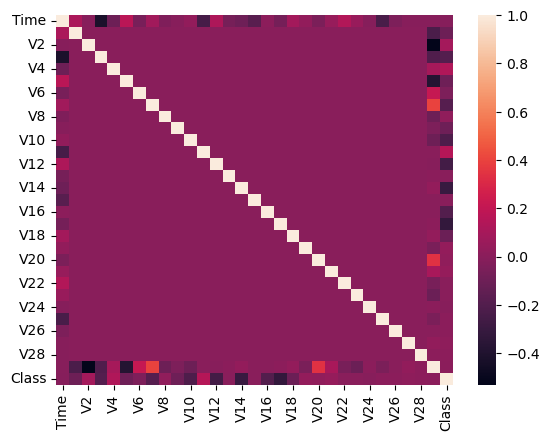

In [27]:
# create the heatmap
sns.heatmap(corr_df)

By looking at our correlation matrix, we arrived at the following conclusions:

    The variables that were a product of PCA are not correlated with each other;
    "Time" seems to be negatively correlated with all of the "Vx" variables;
    "Time" and "Class" seem to have no correlation;
    "Class" seem to be negatively correlated with some of the "Vx" variables, and not correlated at all with others.

## 1.2 IMBALANCED DATA

In [28]:
df1= df.toPandas()
df1= df1.sample(frac=1)

In [29]:
# amount of fraud classes 492 rows.
fraud_df = df1.loc[df1['Class'] == 1]
non_fraud_df = df1.loc[df1['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.shape

(984, 33)

Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


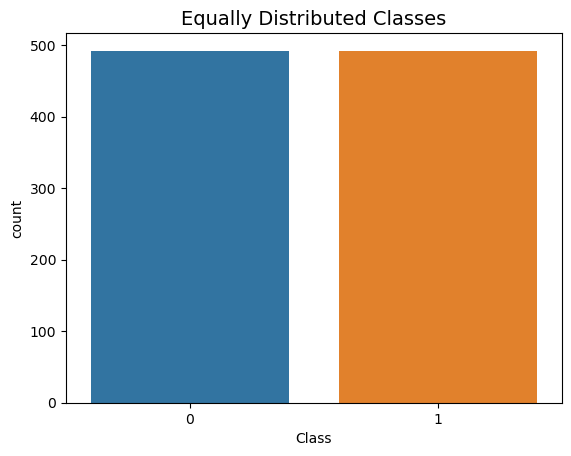

In [30]:
#Plot Distribution of the Classes
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot(x ='Class', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

## 1.3 VISUALIZATION WITH BALANCED DATA

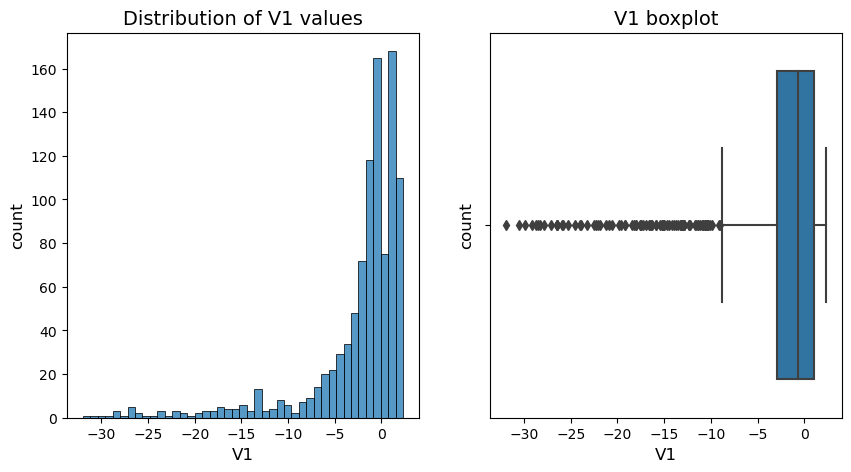

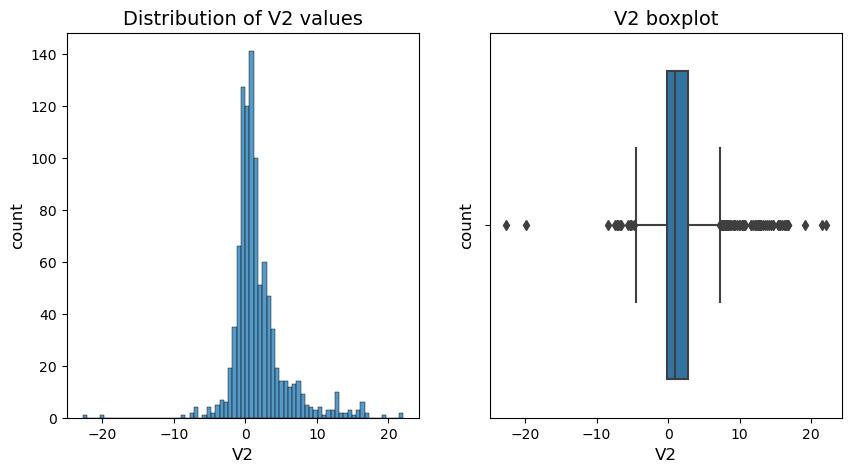

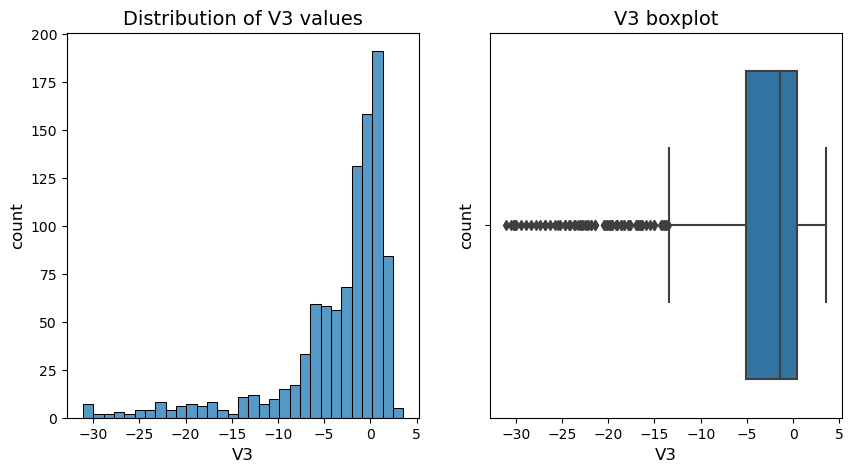

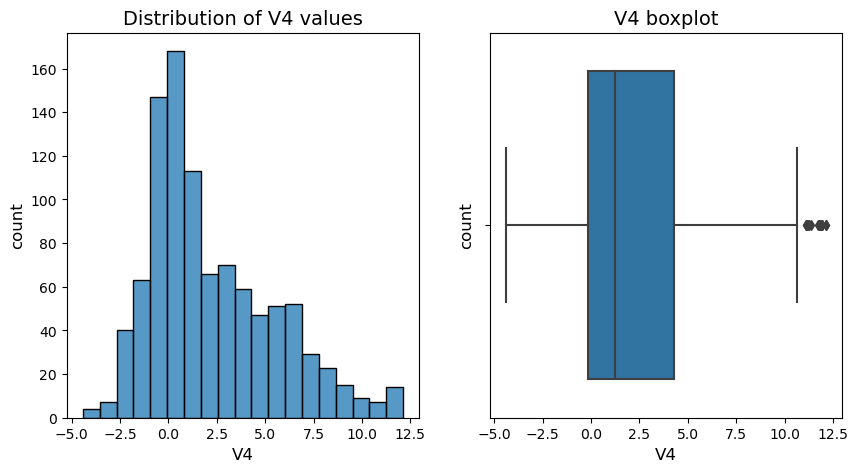

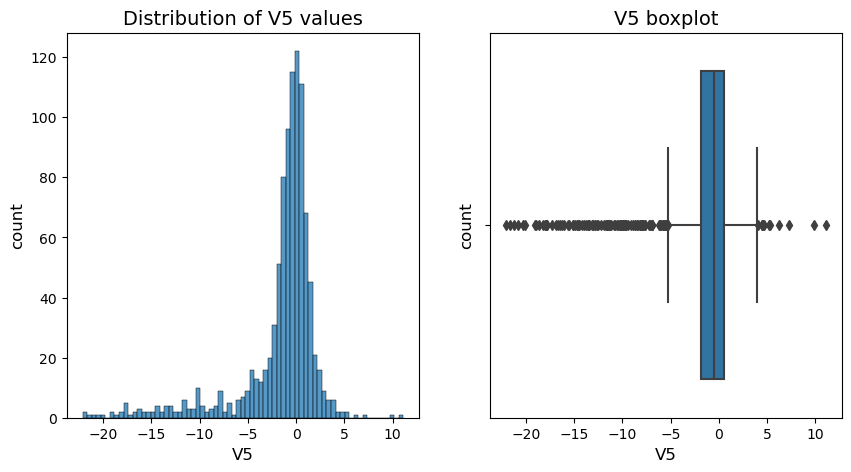

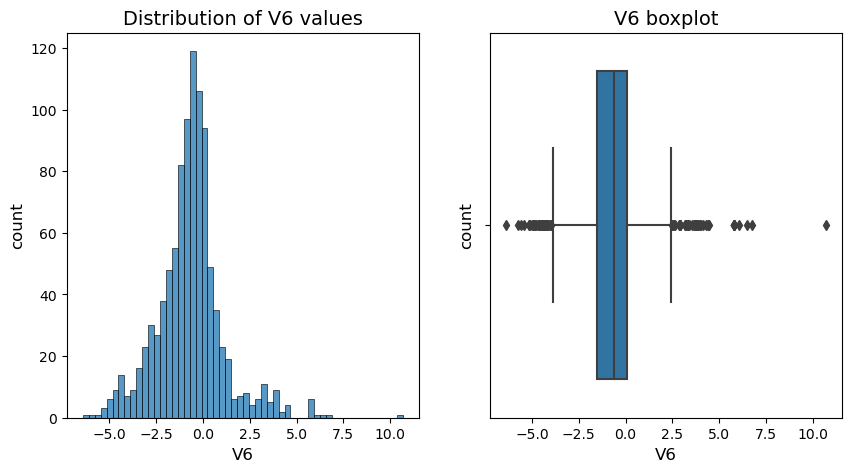

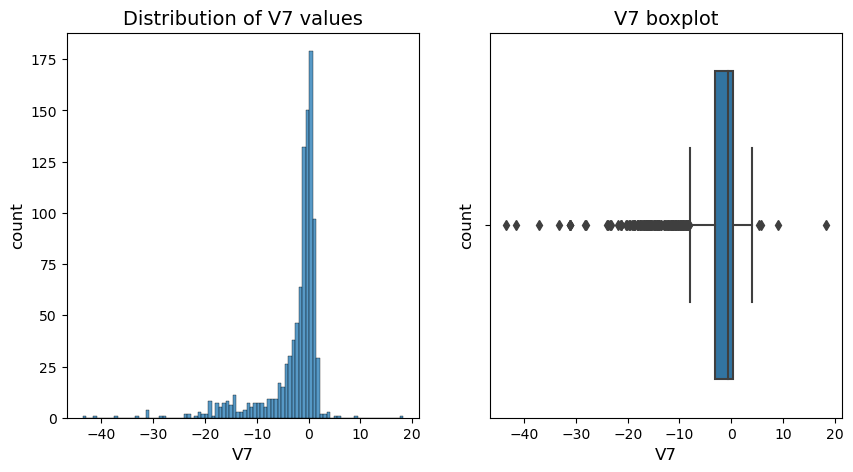

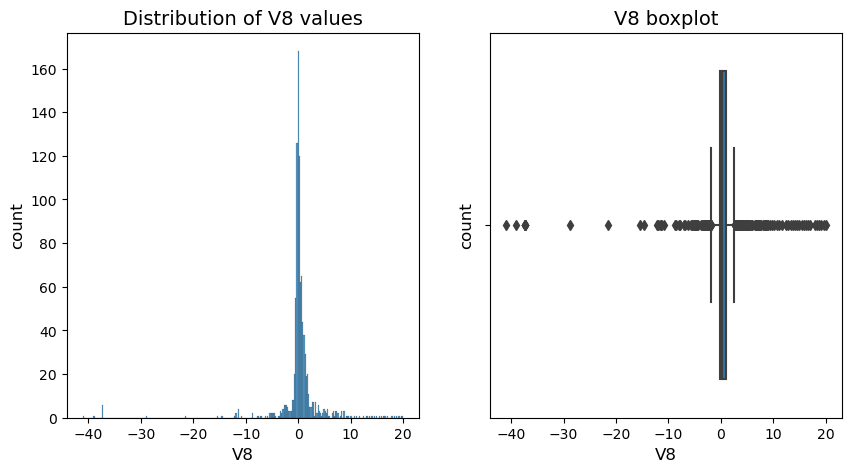

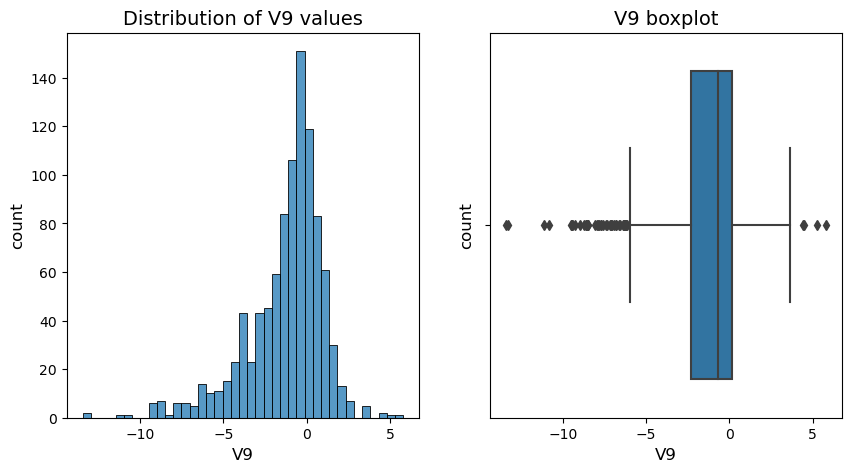

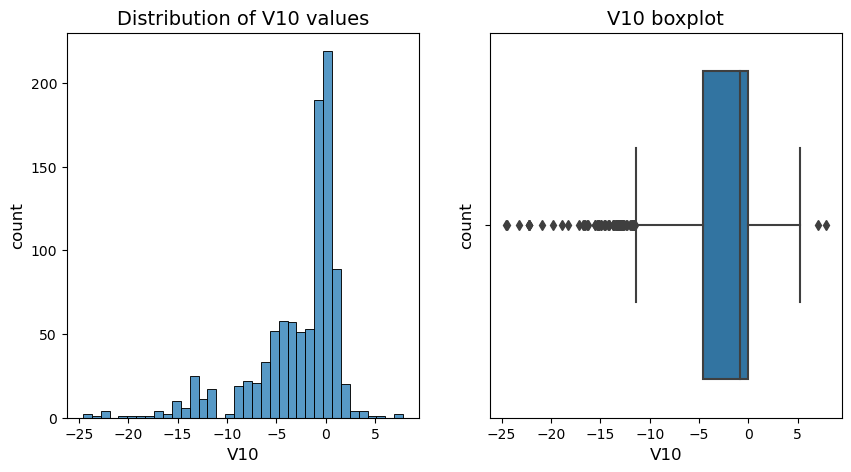

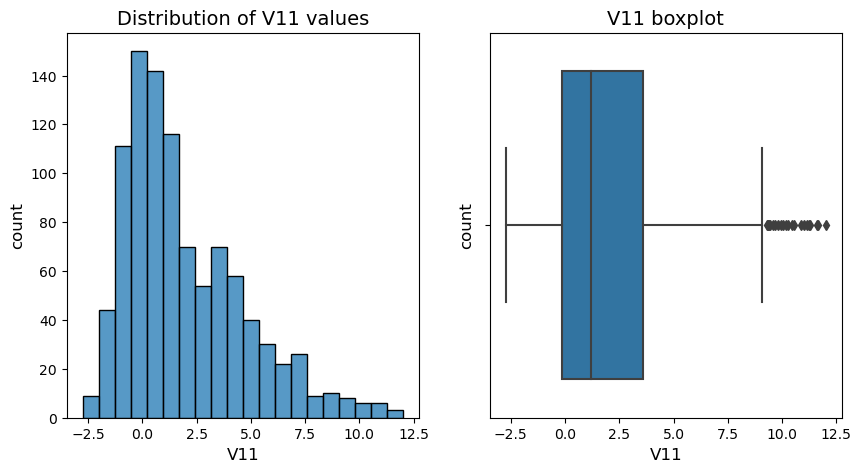

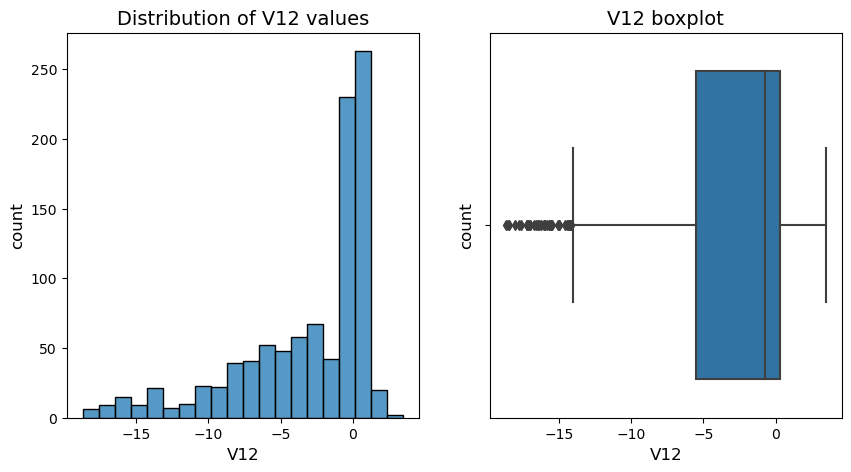

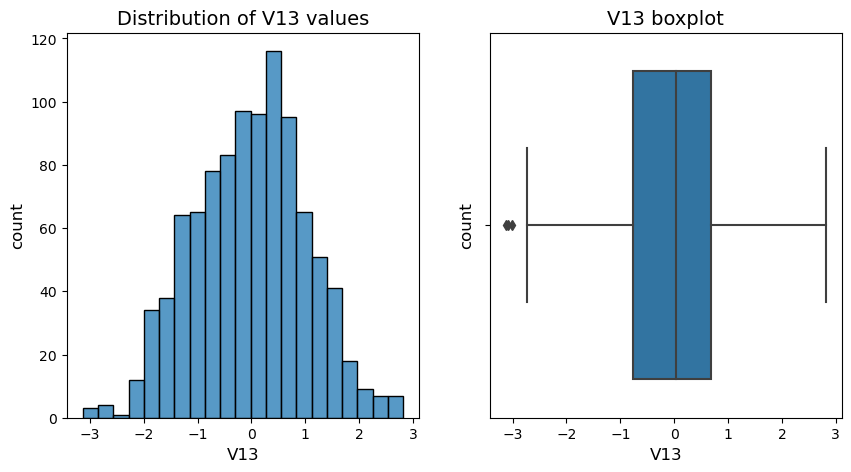

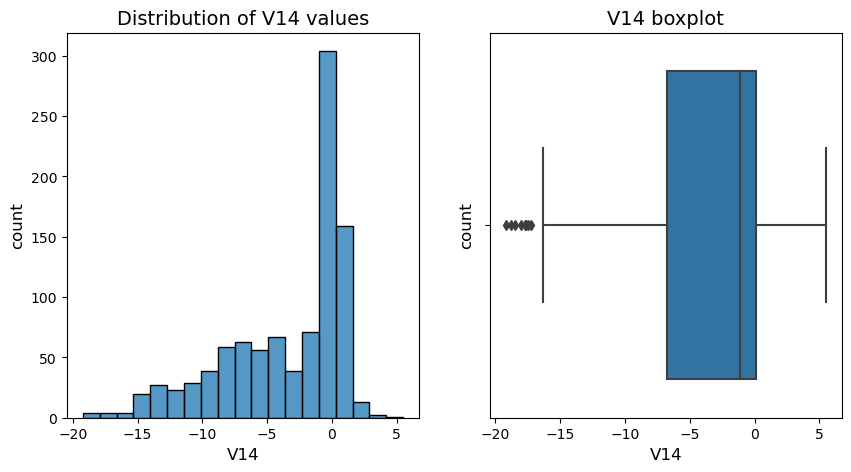

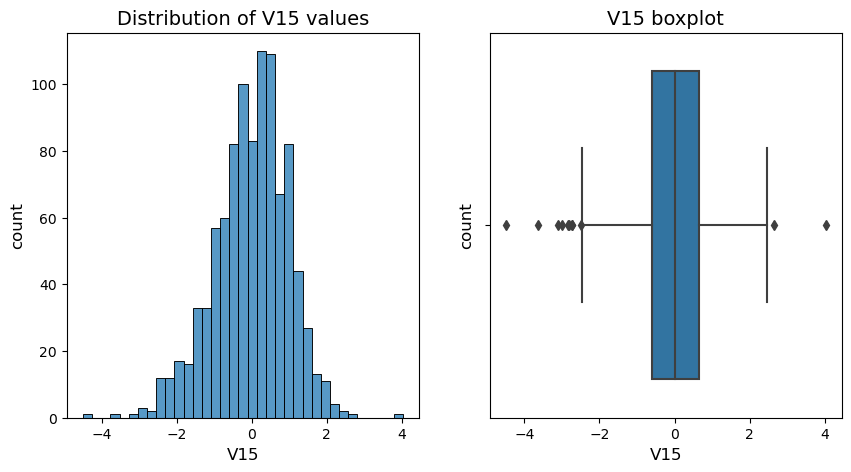

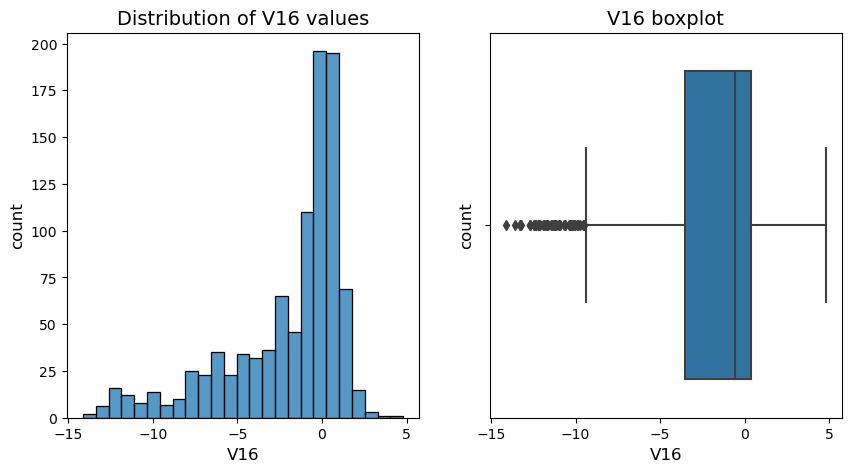

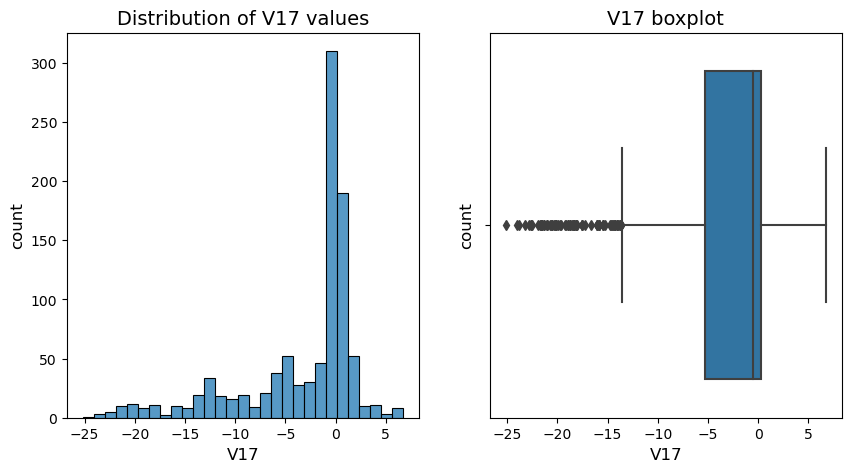

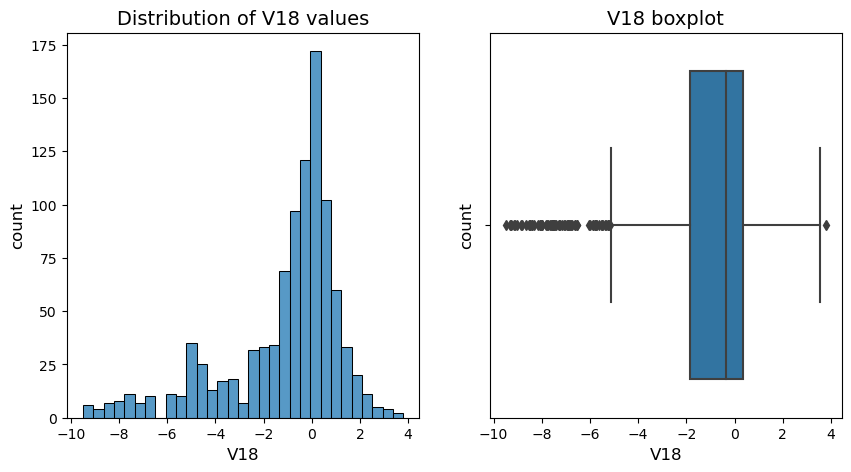

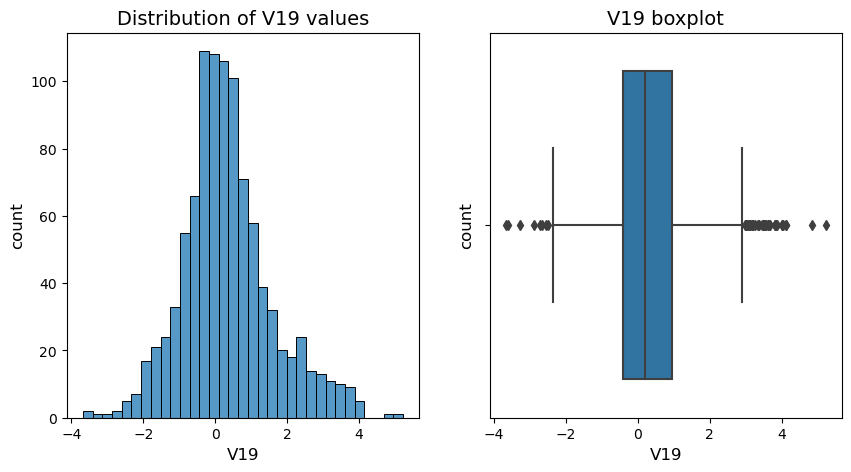

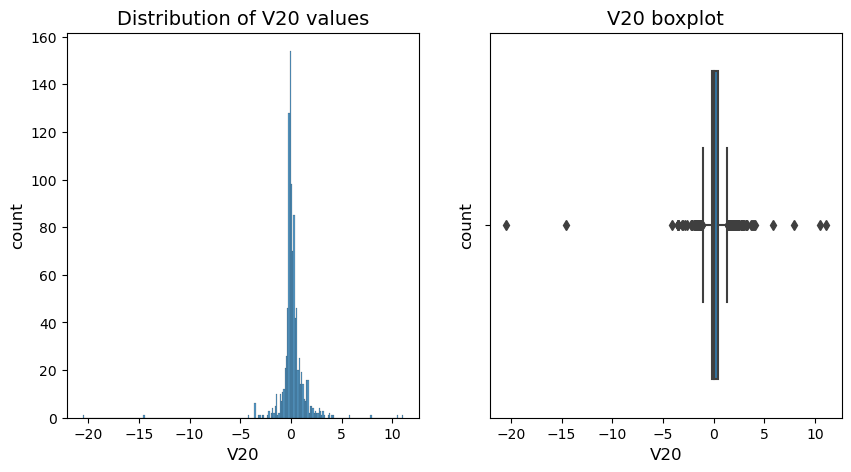

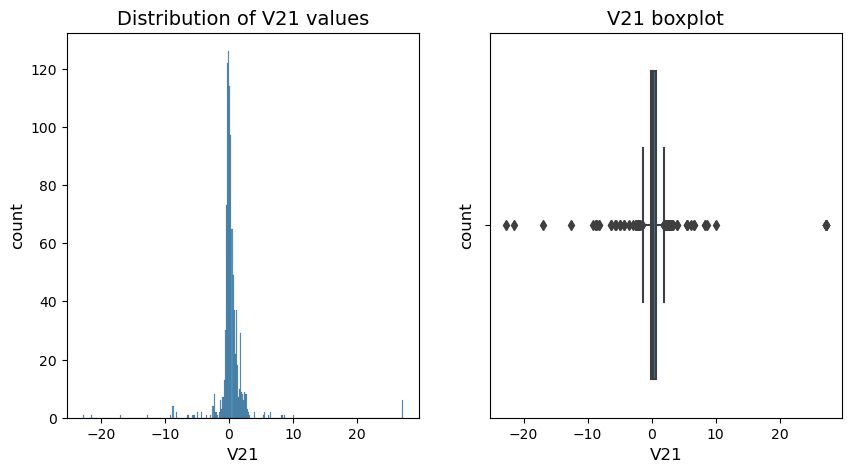

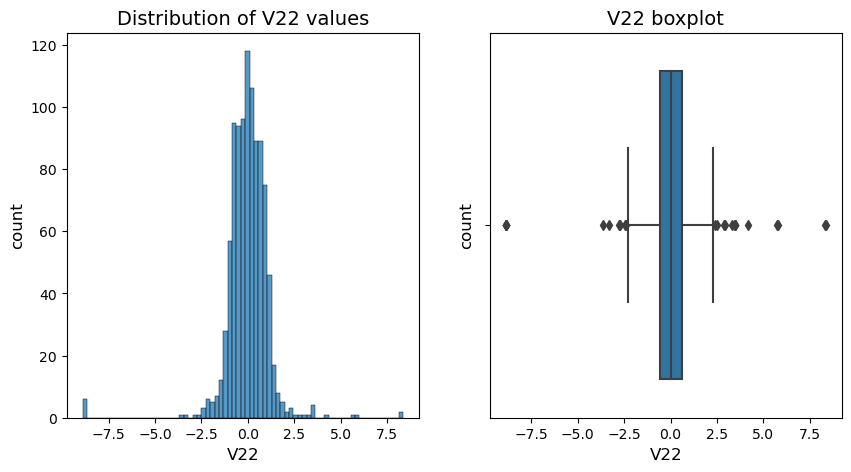

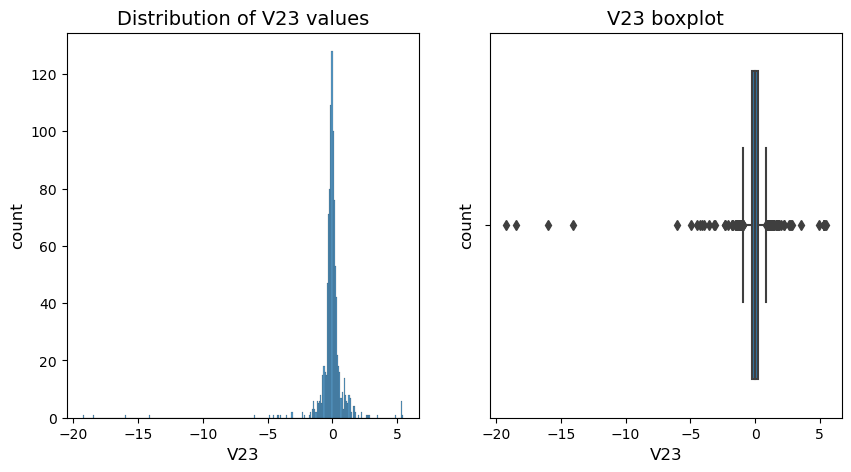

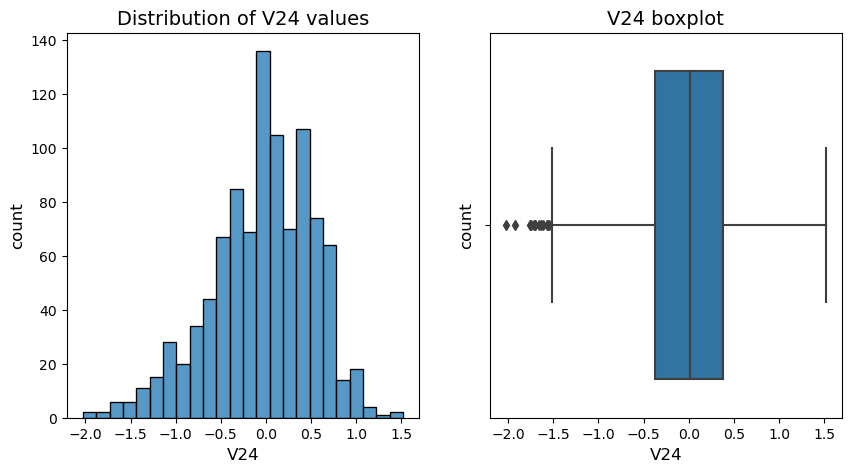

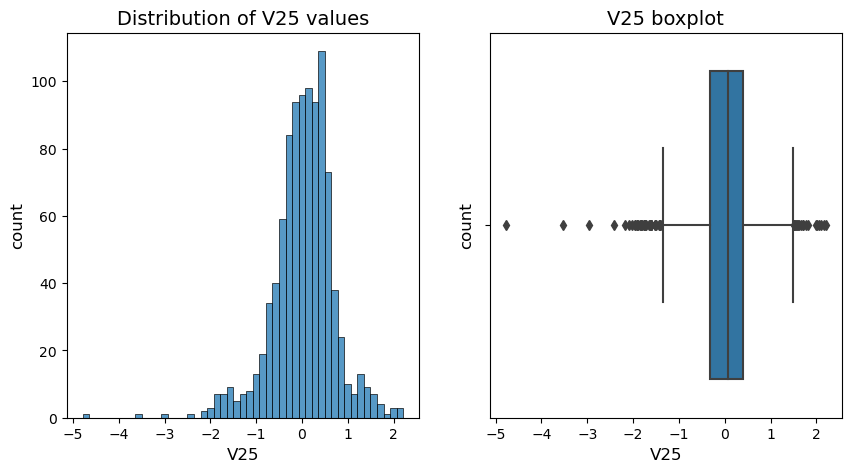

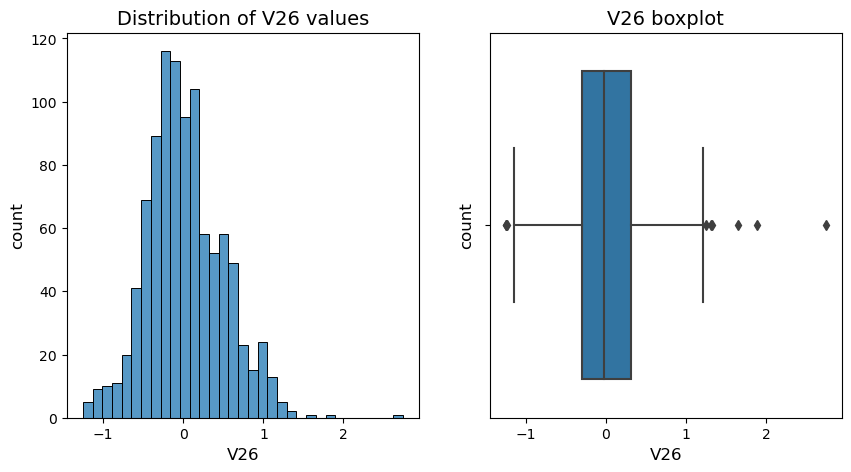

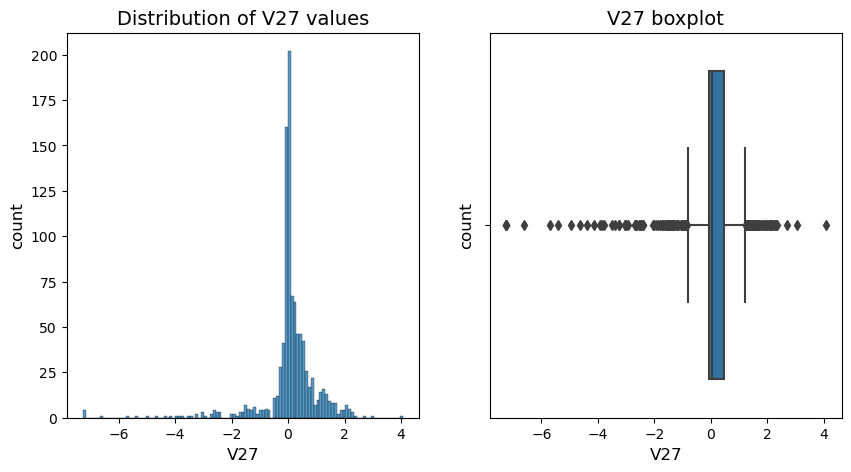

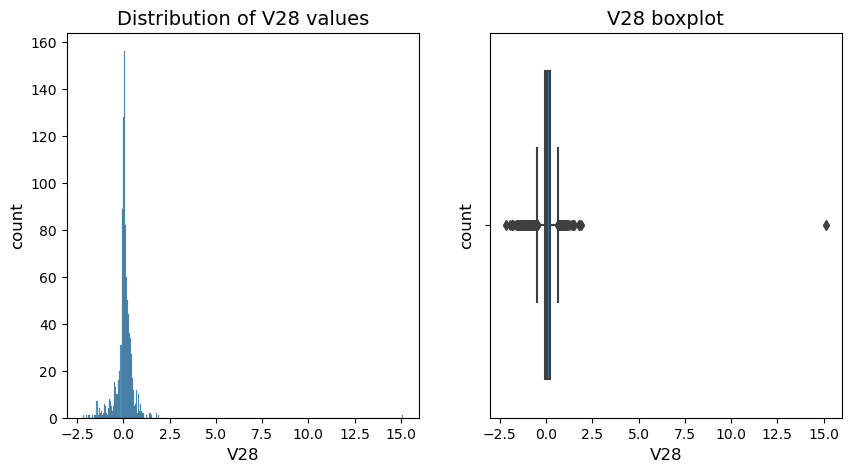

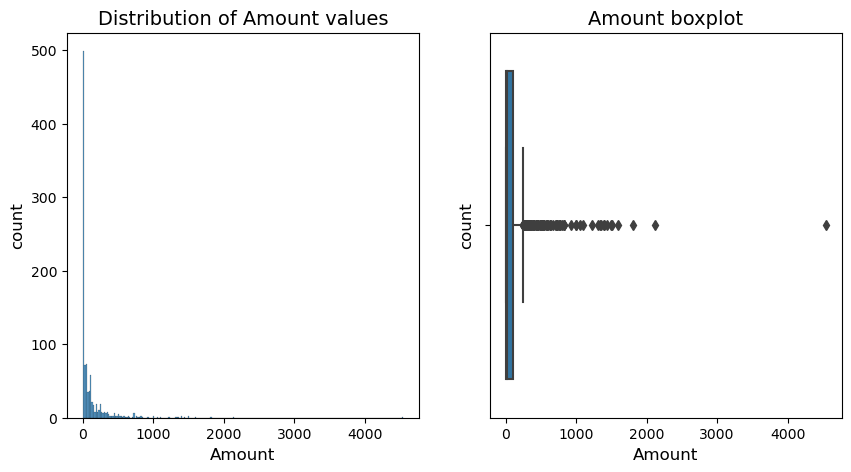

In [31]:
#Histogram distribution
for i in new_df.loc[:, ~new_df.columns.isin(['Time','Class','IsFraud','time_udf'])]:
    plt.figure(figsize = [10,5]);
    plt.subplot(1,2,1);
    sns.histplot(new_df [i]);
    plt.title('Distribution of {} values'.format(i) , size = 14);
    plt.xlabel(i , size = 12);
    plt.ylabel("count", size = 12);
    
    plt.subplot(1,2,2);
    sns.boxplot(data = new_df, x = i);
    plt.title('{} boxplot'.format(i) , size = 14);
    plt.xlabel(i , size = 12);
    plt.ylabel("count", size = 12);
    plt.show()

In [32]:
#Normality checking
def is_normal(x, treshhold = 0.05):
    k2,p = stats.normaltest(x)
    print(p)
    print(p > treshhold)
    print('\n')
    return p > treshhold

for name in list(new_df.loc[:, ~new_df.columns.isin(['Time','Class','IsFraud','time_udf'])]):
    is_normal(np.array(new_df[name]))

3.868339377341307e-121
False


1.2813229306122372e-68
False


2.2993197913927596e-96
False


5.483167326172279e-21
False


6.648580275891041e-104
False


1.4126784407830354e-33
False


3.081784878612536e-127
False


3.3462372488511344e-187
False


4.105400069677789e-54
False


3.0568849551347805e-74
False


3.1733778041323683e-31
False


1.7969388959598736e-45
False


0.18557142876595803
True


1.8738731433273077e-26
False


1.831623090664434e-08
False


5.778724477988625e-47
False


6.154965529879684e-55
False


4.255698328648852e-48
False


1.1458915008316794e-13
False


3.75948682552846e-213
False


4.336018265015155e-201
False


5.347458155332066e-106
False


1.0259853819873889e-299
False


4.319302887074112e-10
False


2.725397143306974e-41
False


1.9673387165378843e-13
False


1.2532154075294905e-140
False


0.0
False


7.09993538932316e-294
False




In [33]:
# Check skeness
new_df.loc[:, ~new_df.columns.isin(['Time','Class','IsFraud','time_udf'])].skew()

V1        -2.634146
V2         1.248808
V3        -2.178490
V4         0.848849
V5        -2.275614
V6         0.700442
V7        -2.670756
V8        -3.682090
V9        -1.307736
V10       -1.752902
V11        1.043888
V12       -1.354009
V13       -0.033014
V14       -0.998529
V15       -0.401000
V16       -1.375453
V17       -1.514132
V18       -1.360229
V19        0.543216
V20       -3.910479
V21        3.750398
V22       -1.507817
V23       -7.591863
V24       -0.531891
V25       -0.800538
V26        0.491441
V27       -2.730450
V28       12.868481
Amount     7.376303
dtype: float64

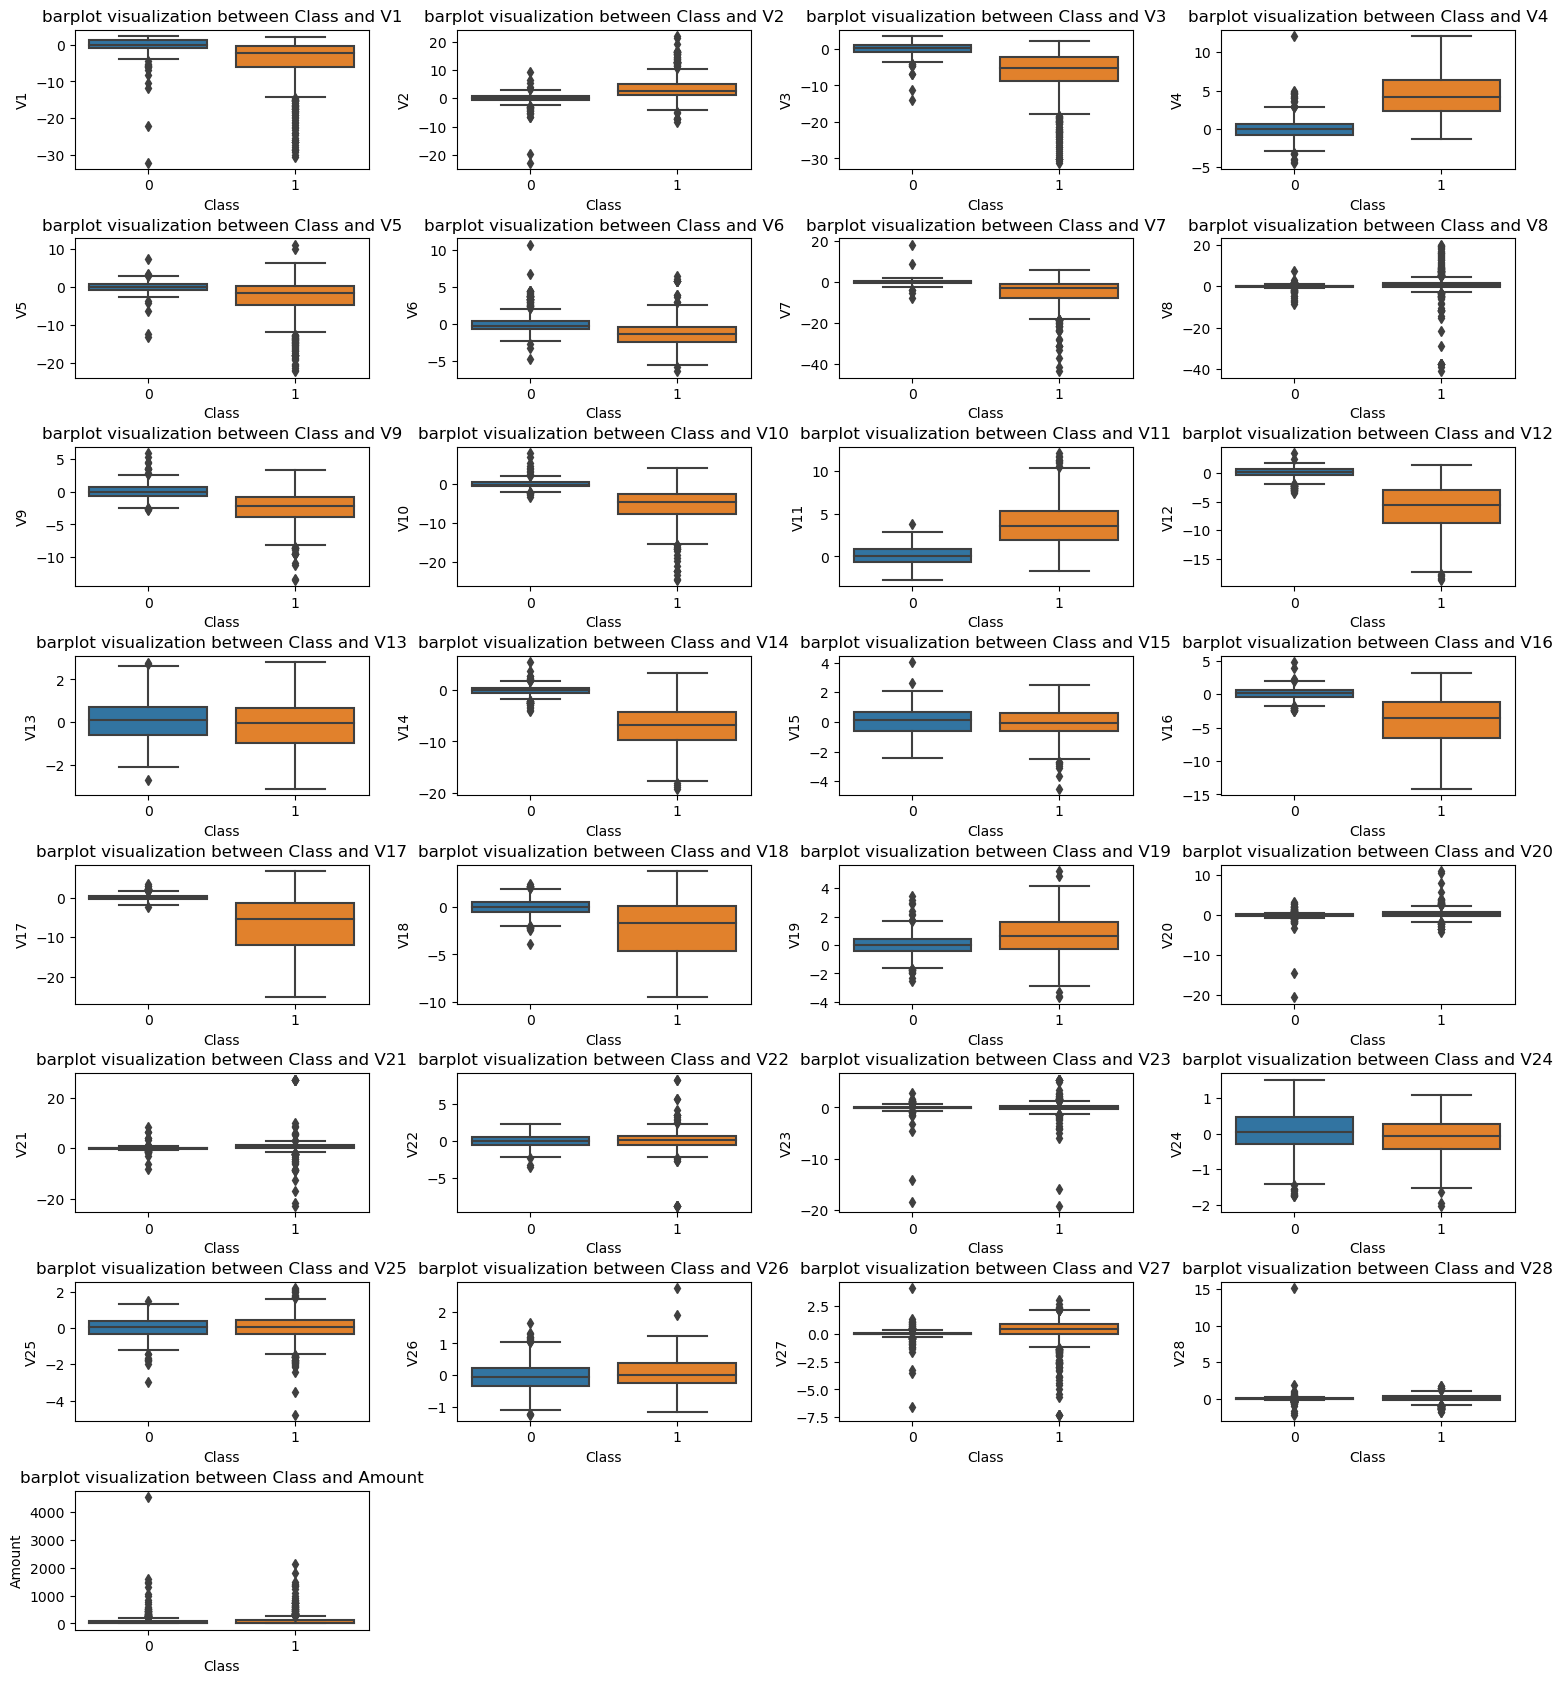

In [34]:
# Visualization of the relation between each variable and Class
x = 0
plt.figure(figsize = [18,20]);
for i in new_df.loc[:, ~new_df.columns.isin(['Time','Class','IsFraud','time_udf'])] :
    plt.subplot(8,4,x+1)
    sns.boxplot(data = new_df, x = 'Class', y = i)
    plt.title("barplot visualization between Class and {}".format(i), size = 12);
    x = x +1
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.3,  
                    hspace=0.5) 
plt.show()

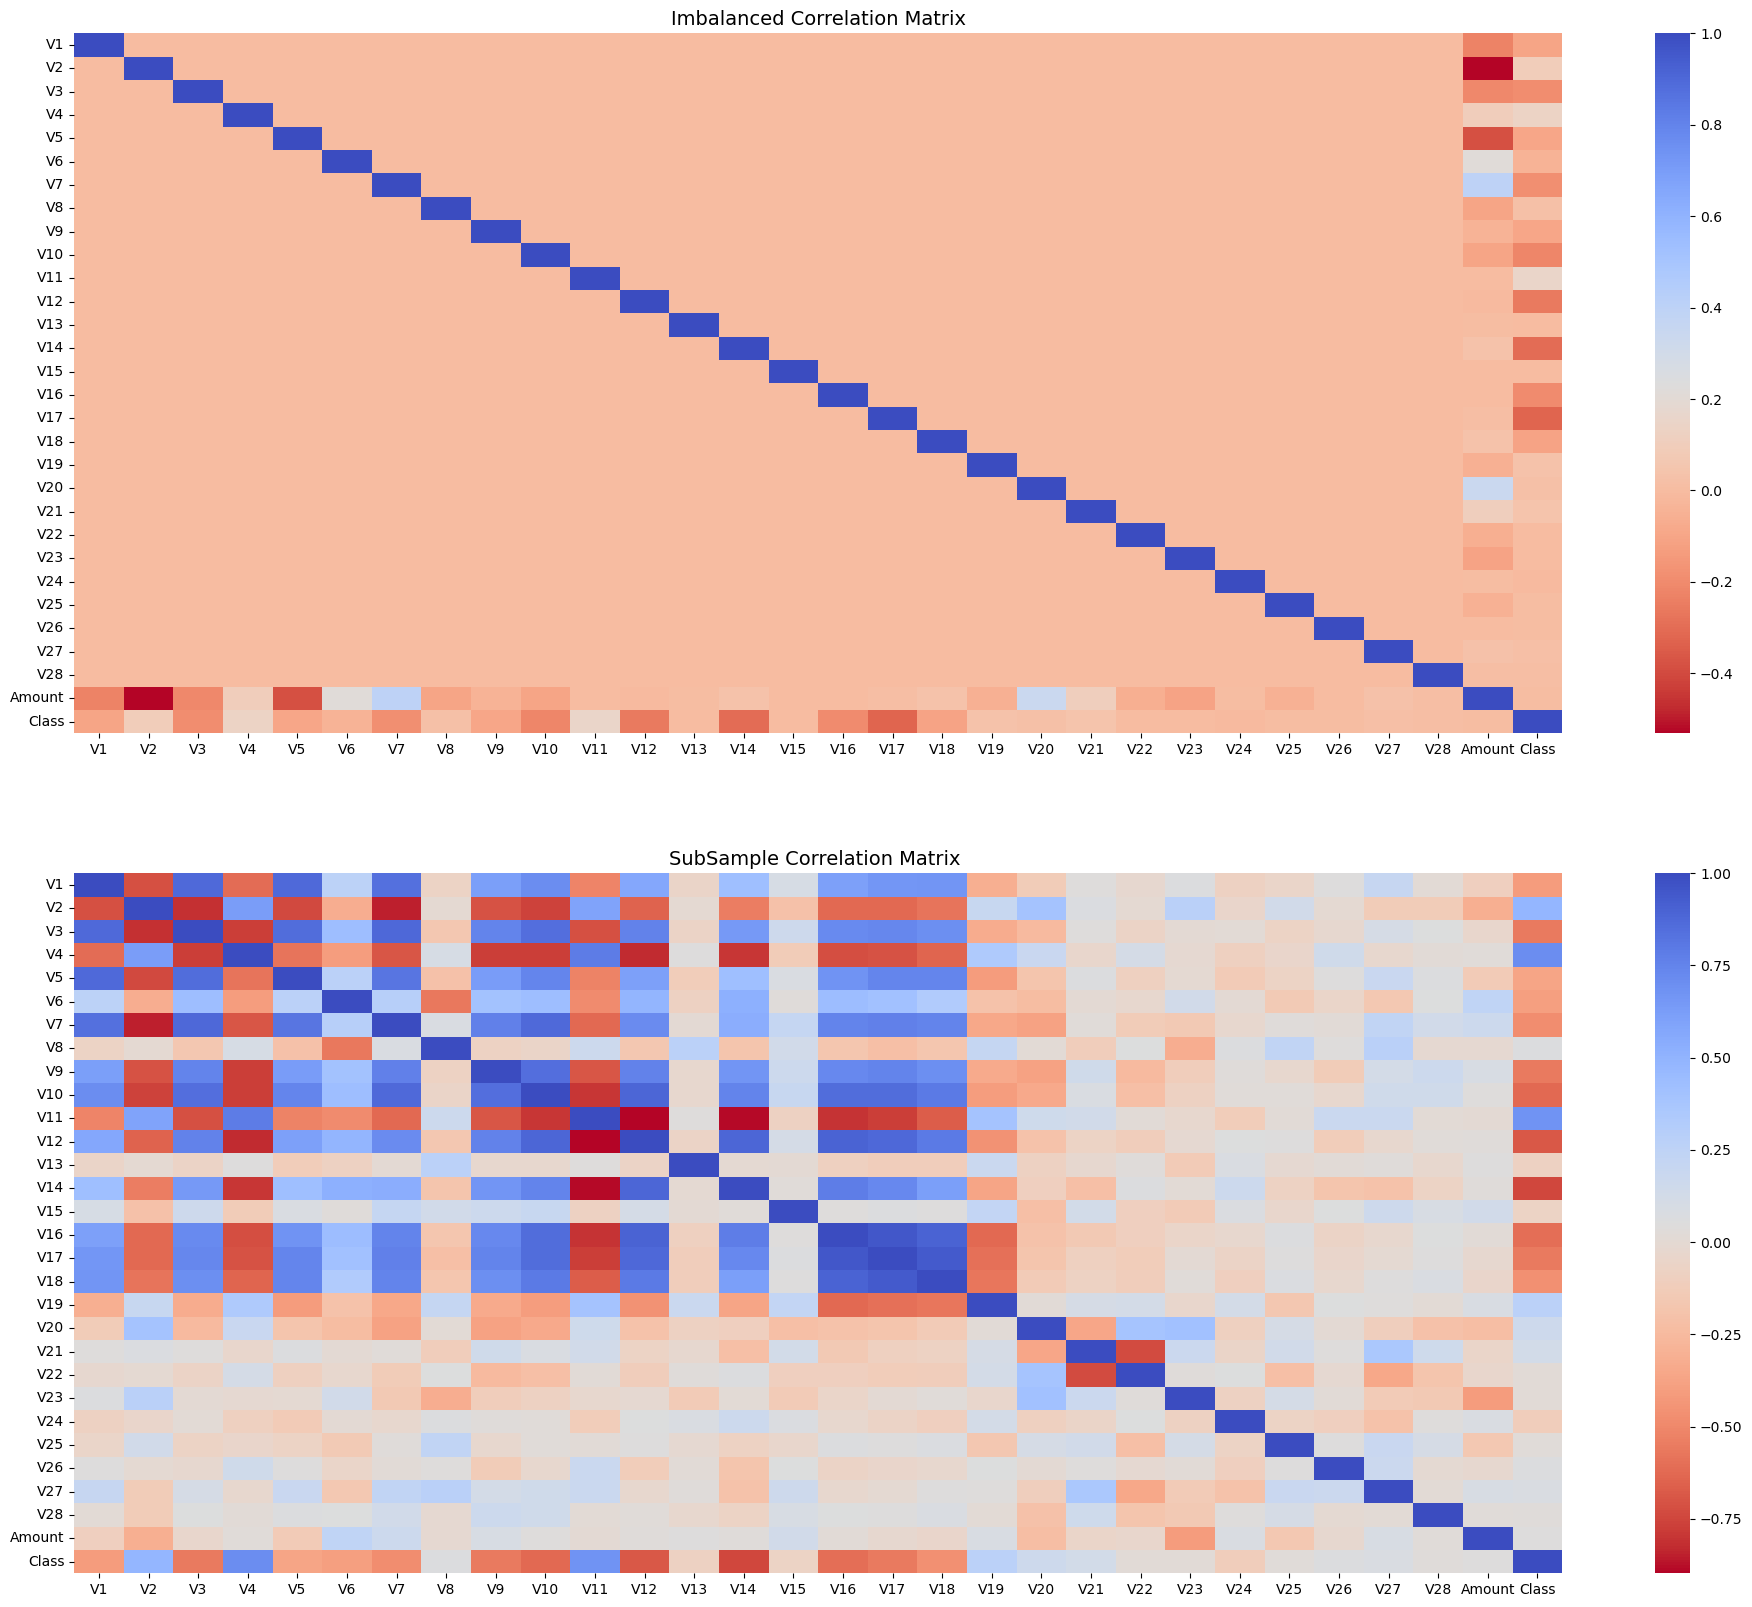

In [35]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

df1= df.toPandas()
df1= df1.sample(frac=1)
df2 = df1.loc[:, ~df1.columns.isin(['Time','IsFraud','time_udf'])]
new_df1= new_df.loc[:, ~new_df.columns.isin(['Time','IsFraud','time_udf'])]

# Entire DataFrame
corr = df2.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix", fontsize=14)


sub_sample_corr = new_df1.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix ', fontsize=14)
plt.show()

In [36]:
print('Sorted Correlation values with Class:')
print(new_df1[new_df1.columns[1:]].corr()['Class'][:-1].sort_values())

Sorted Correlation values with Class:
V14      -0.745240
V12      -0.685909
V10      -0.625372
V16      -0.603605
V3       -0.562799
V9       -0.560200
V17      -0.558641
V7       -0.478115
V18      -0.463243
V6       -0.399925
V5       -0.368839
V24      -0.117320
V13      -0.082690
V15      -0.073008
V22       0.014156
V23       0.014837
V25       0.023600
V28       0.031192
Amount    0.048751
V8        0.059024
V26       0.062083
V27       0.080426
V21       0.125549
V20       0.160942
V19       0.269741
V2        0.481217
V11       0.676598
V4        0.710557
Name: Class, dtype: float64


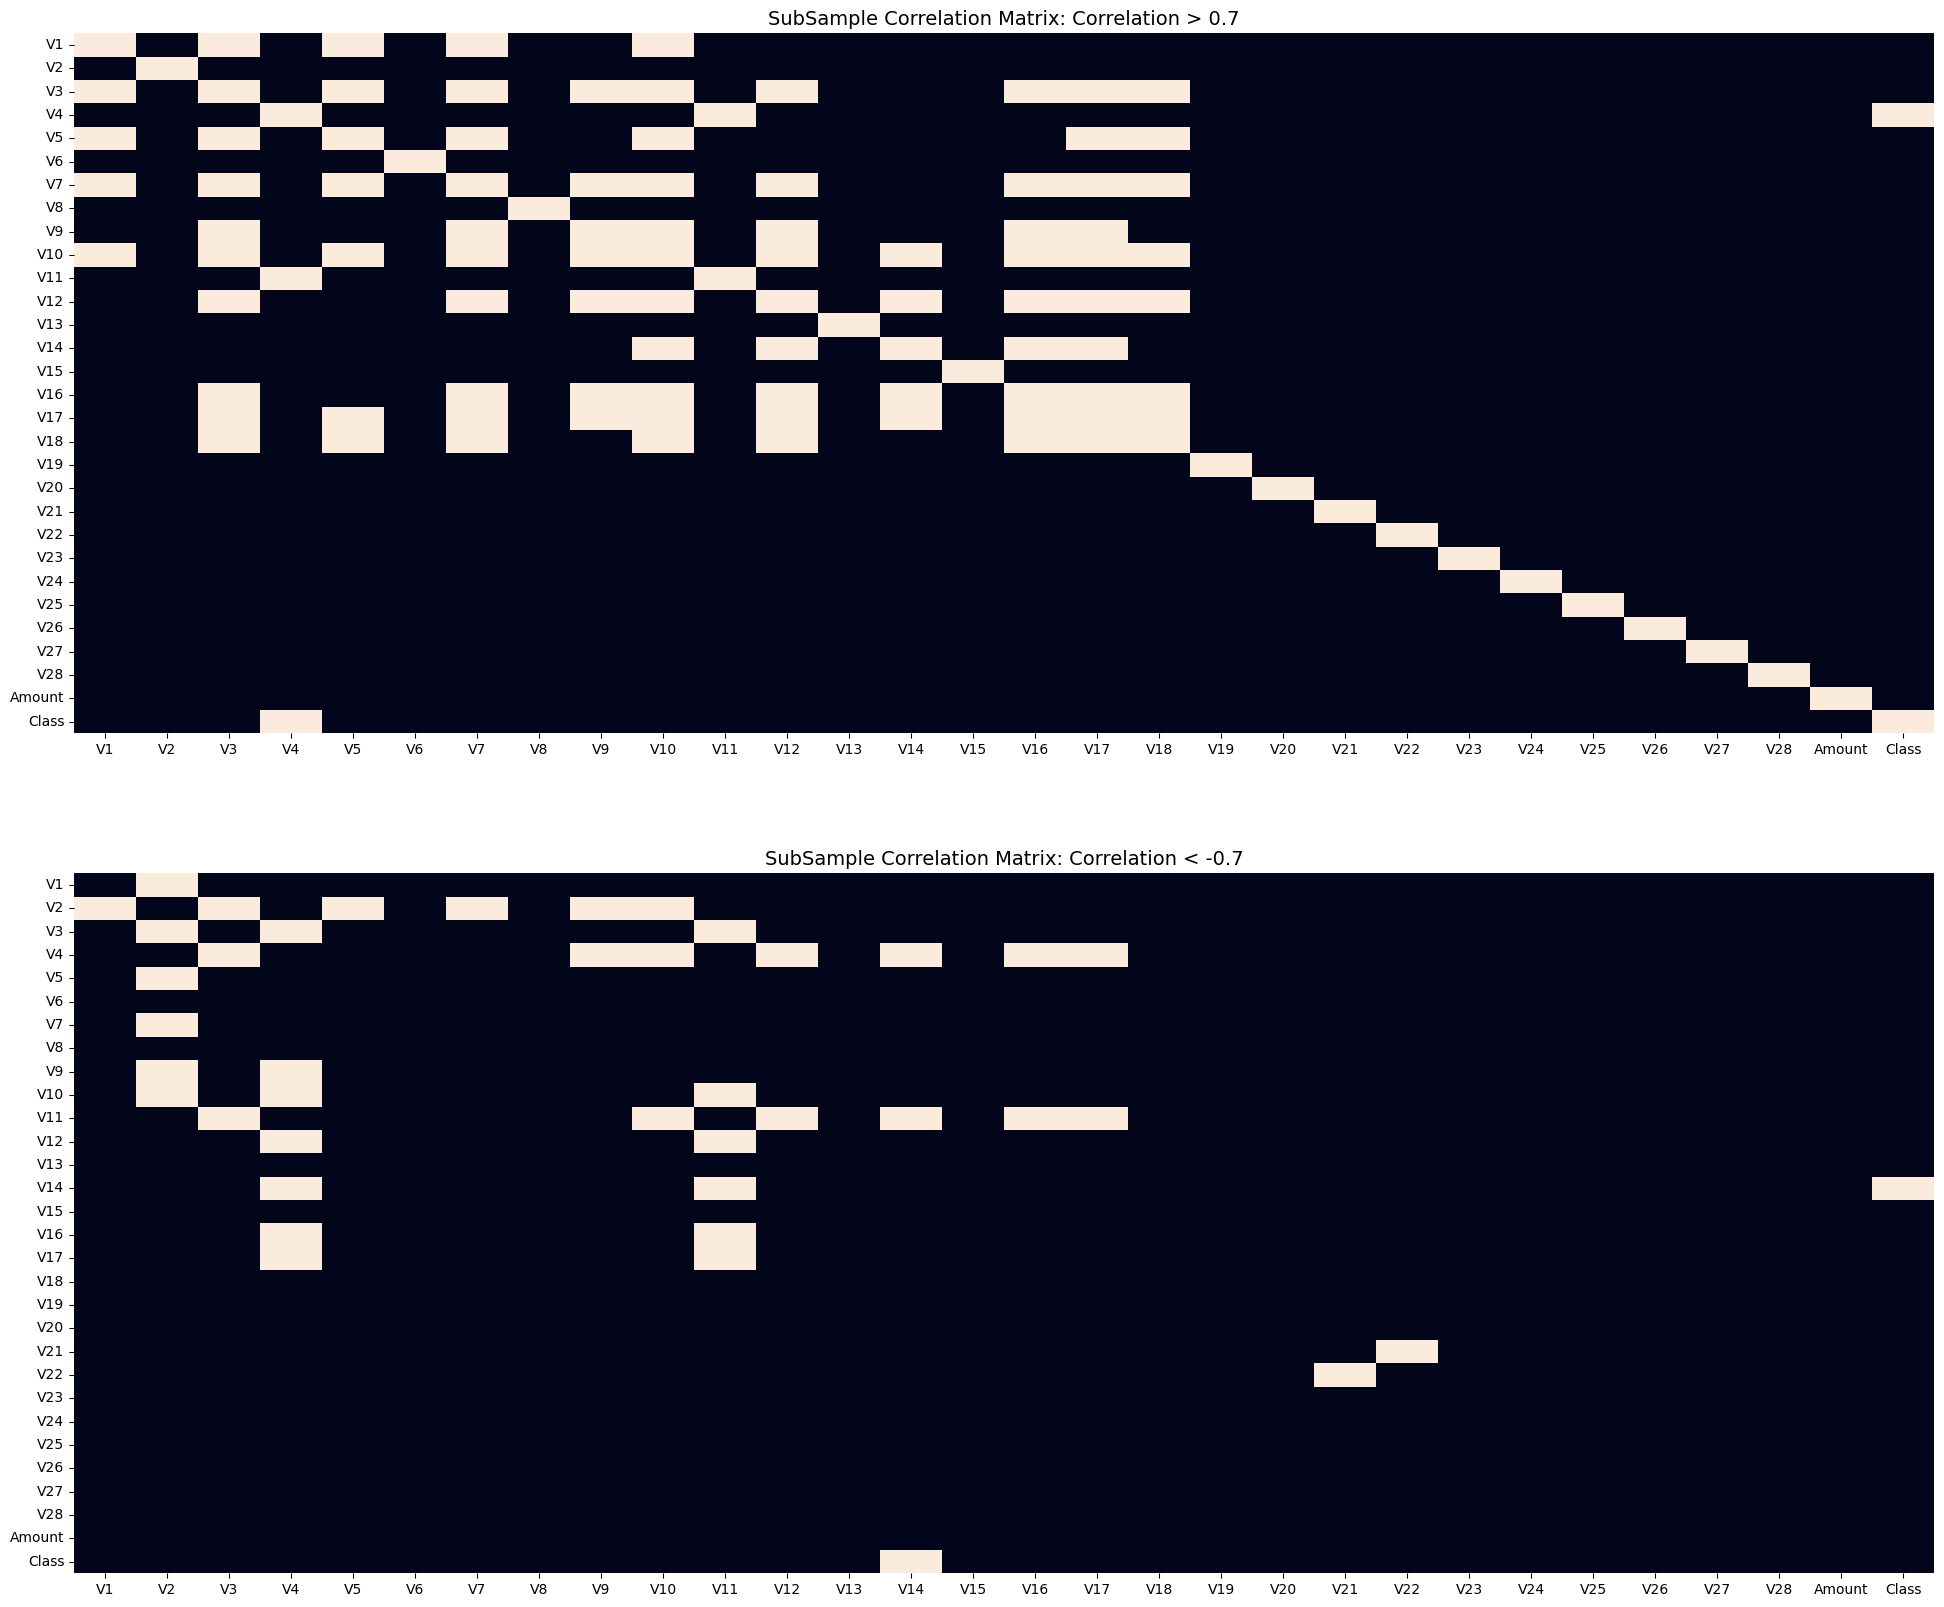

In [37]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

sub_sample_corr = new_df1.corr()

sns.heatmap(sub_sample_corr > 0.7, cbar=False, annot_kws={'size':20}, ax=ax1)
ax1.set_title('SubSample Correlation Matrix: Correlation > 0.7', fontsize=14)

sns.heatmap(sub_sample_corr <-0.7,  cbar=False, annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix: Correlation < -0.7', fontsize=14)
plt.show()

In [38]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from collections import OrderedDict
corrs = OrderedDict([(col, pearsonr(new_df1[col], new_df1['Class'] == 1)) for col in new_df1.loc[:, ~new_df1.columns.isin(['Time','Class'])]])
corrs = pd.DataFrame(index = corrs.keys(), data={
        'corr_coef': [corr[0] for corr in corrs.values()],
        'p_value': [corr[1] for corr in corrs.values()],
    })

corrs.applymap(lambda xx : abs(xx)).sort_values(by='corr_coef', ascending=False).rename(columns={
        'corr_coef': 'absolute correlation coefficient'
    })

absolute correlation coefficient        p_value
V14                             0.745240  4.947311e-175
V4                              0.710557  4.486171e-152
V12                             0.685909  9.970360e-138
V11                             0.676598  1.130153e-132
V10                             0.625372  6.673586e-108
V16                             0.603605   1.018481e-98
V3                              0.562799   2.725060e-83
V9                              0.560200   2.220038e-82
V17                             0.558641   7.743372e-82
V2                              0.481217   3.578796e-58
V7                              0.478115   2.402811e-57
V18                             0.463243   1.696563e-53
V1                              0.414144   4.614722e-42
V6                              0.399925   4.344506e-39
V5                              0.368839   4.508289e-33
V19                             0.269741   7.256067e-18
V20                             0.160942   3.869681e-07
V21                             0.125549   7.849126e-05
V24                             0.117320   2.257893e-04
V13                             0.082690   9.458277e-03
V27                             0.080426   1.161135e-02
V15                             0.073008   2.200322e-02
V26                             0.062083   5.154967e-02
V8                              0.059024   6.420128e-02
Amount                          0.048751   1.264571e-01
V28                             0.031192   3.283435e-01
V25                             0.023600   4.596257e-01
V23                             0.014837   6.420337e-01
V22                             0.014156   6.573873e-01

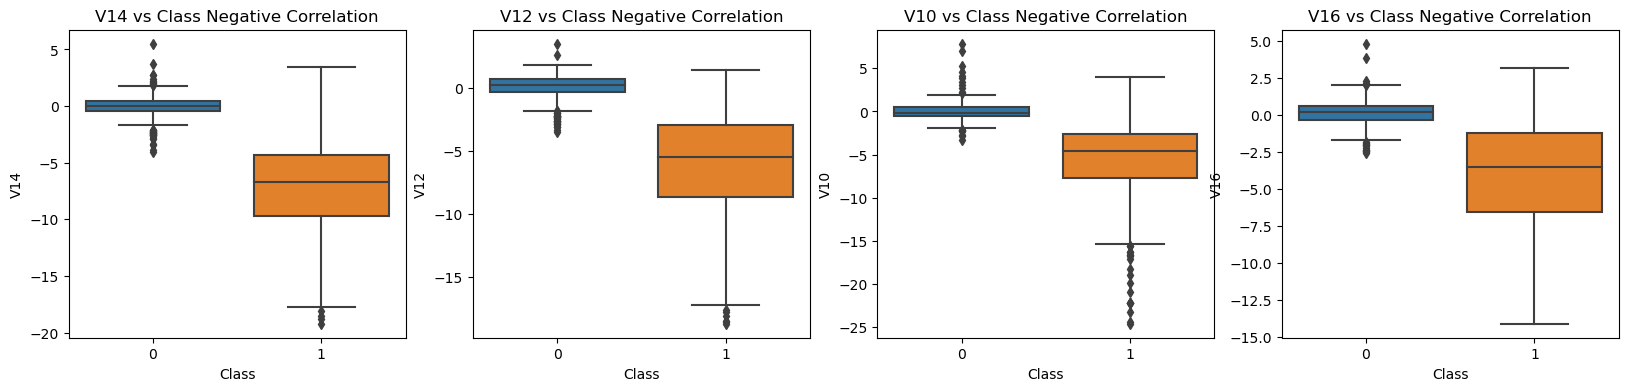

In [39]:
#Bivariate Analysis
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V14", data=new_df1,  ax=axes[0])
axes[0].set_title('V14 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V12", data=new_df1,  ax=axes[1])
axes[1].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df1, ax=axes[2])
axes[2].set_title('V10 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V16", data=new_df1, ax=axes[3])
axes[3].set_title('V16 vs Class Negative Correlation')

plt.show()

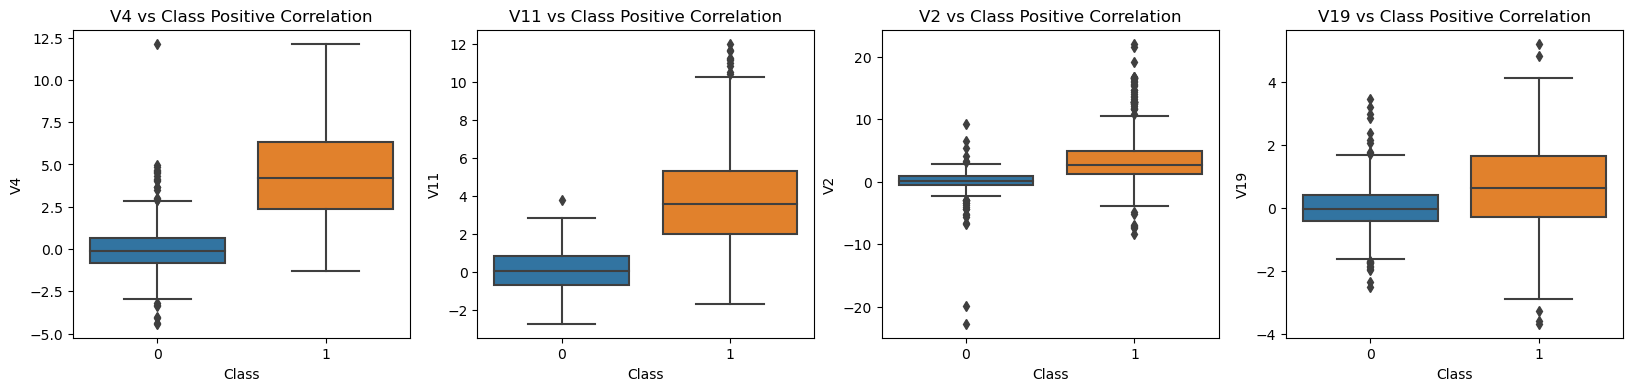

In [40]:
#Bivariate Analysis
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V4", data=new_df1,  ax=axes[0])
axes[0].set_title('V4 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V11", data=new_df1,  ax=axes[1])
axes[1].set_title('V11 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df1, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df1, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

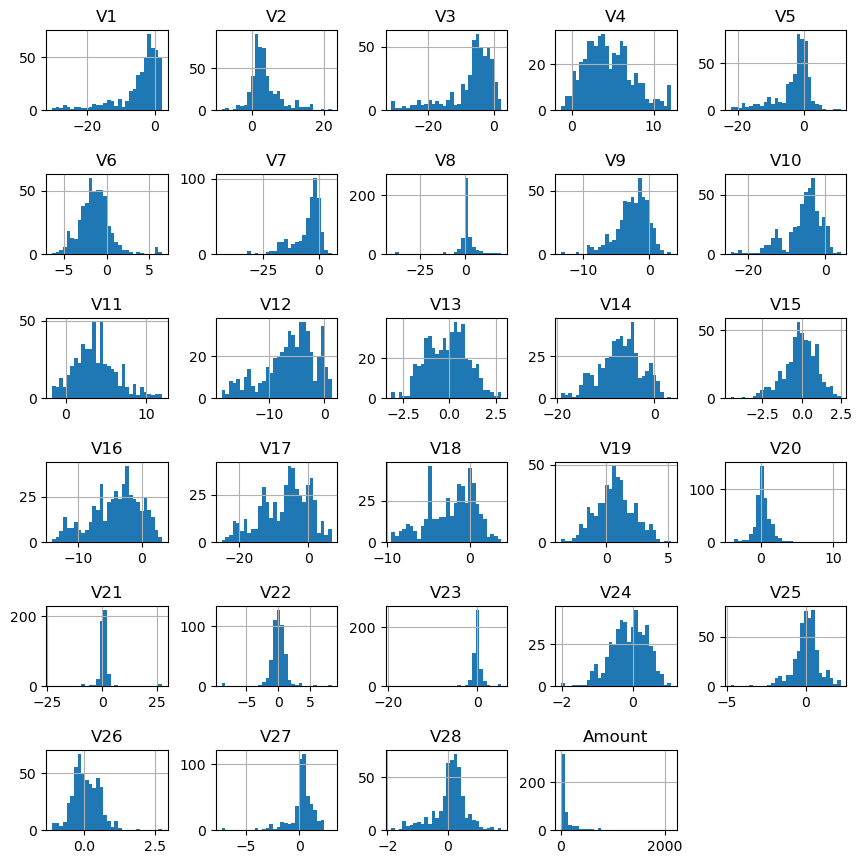

In [41]:
#Histogram distribution if is Fraud
new_df1.loc[:, ~new_df1.columns.isin(['Time','Class'])].loc[new_df['Class'] == 1].hist(bins=30, figsize=(10, 10))
plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.8) 
plt.show()

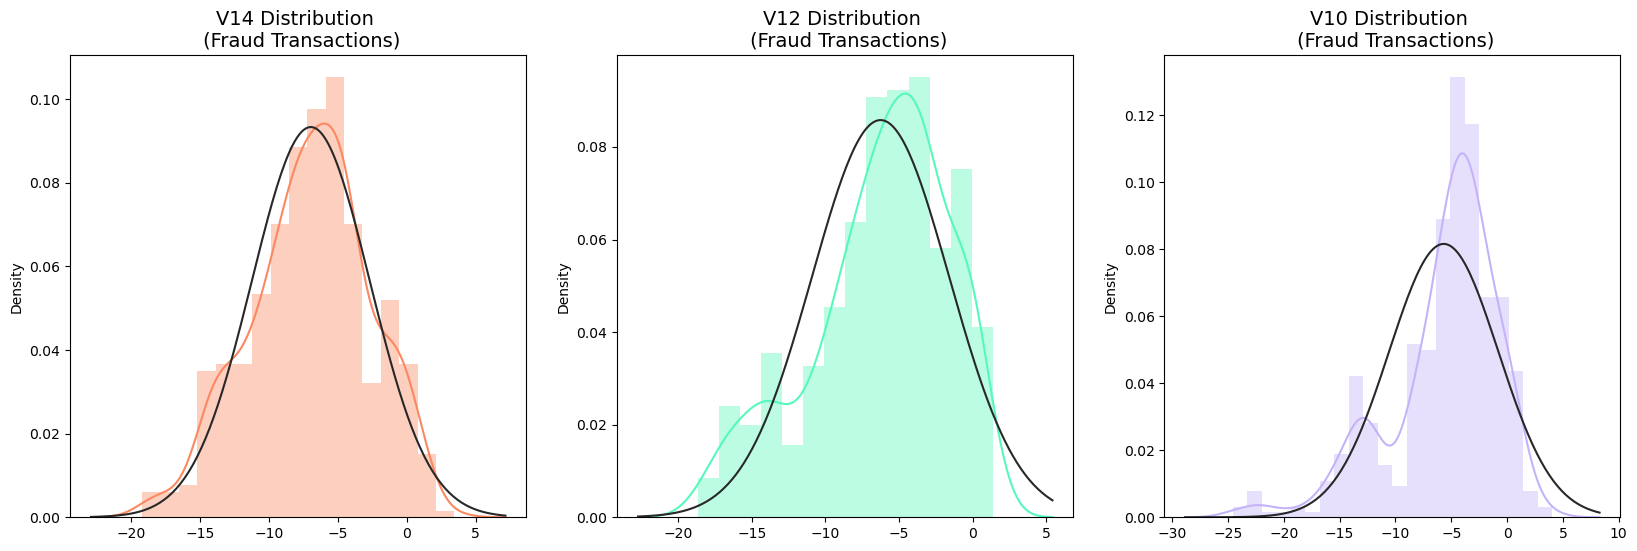

In [42]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df1['V14'].loc[new_df1['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df1['V12'].loc[new_df1['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df1['V10'].loc[new_df1['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

<Figure size 640x480 with 0 Axes>

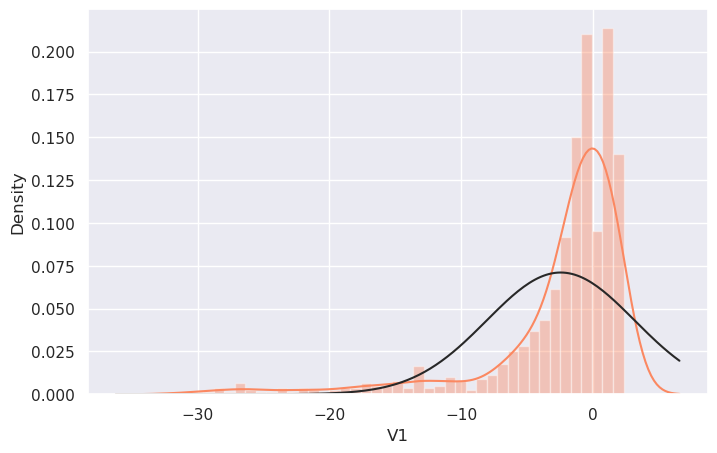

<Figure size 800x500 with 0 Axes>

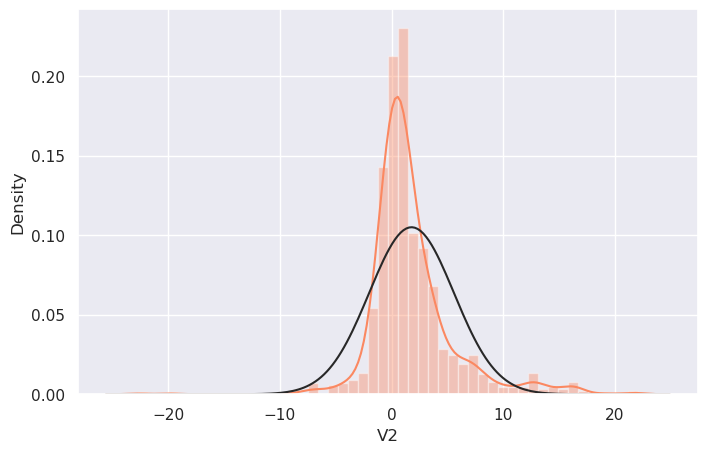

<Figure size 800x500 with 0 Axes>

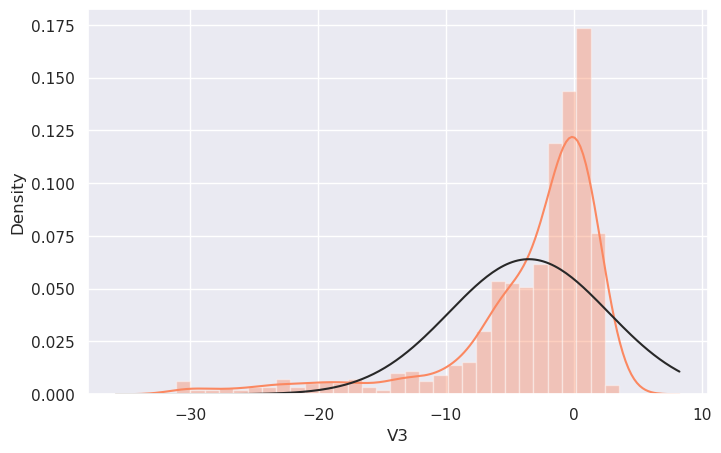

<Figure size 800x500 with 0 Axes>

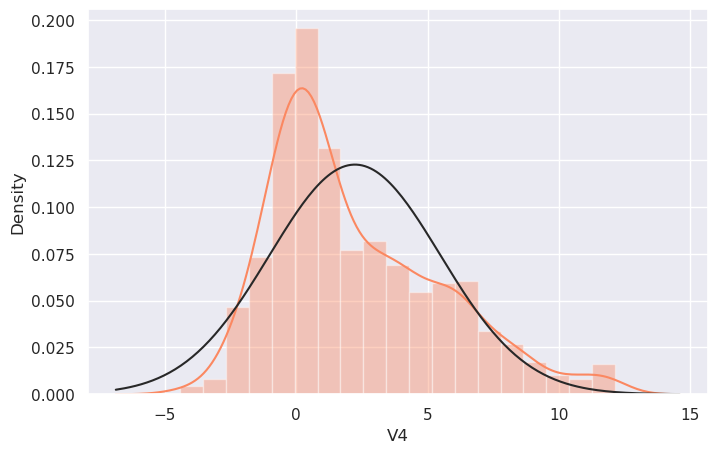

<Figure size 800x500 with 0 Axes>

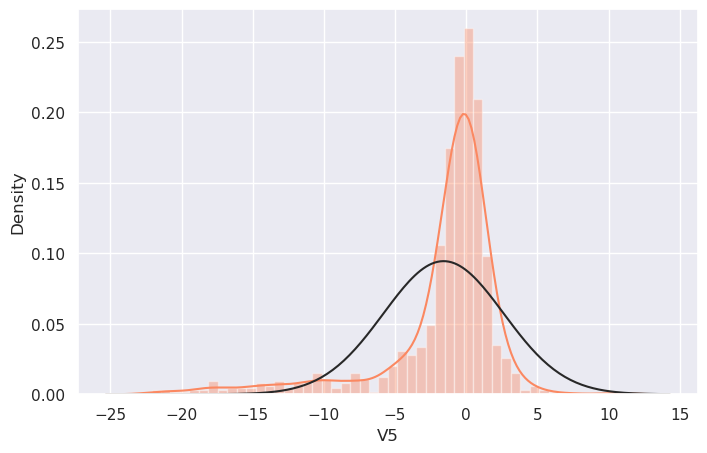

<Figure size 800x500 with 0 Axes>

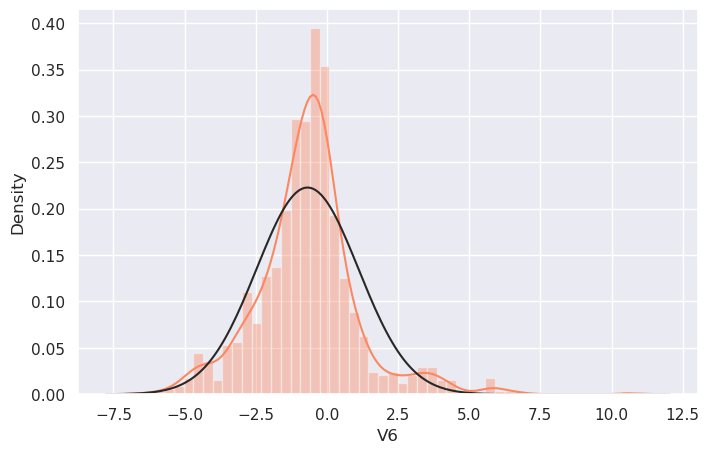

<Figure size 800x500 with 0 Axes>

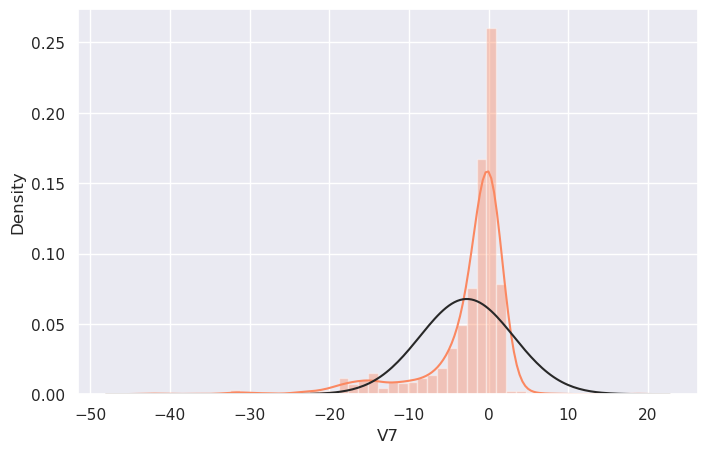

<Figure size 800x500 with 0 Axes>

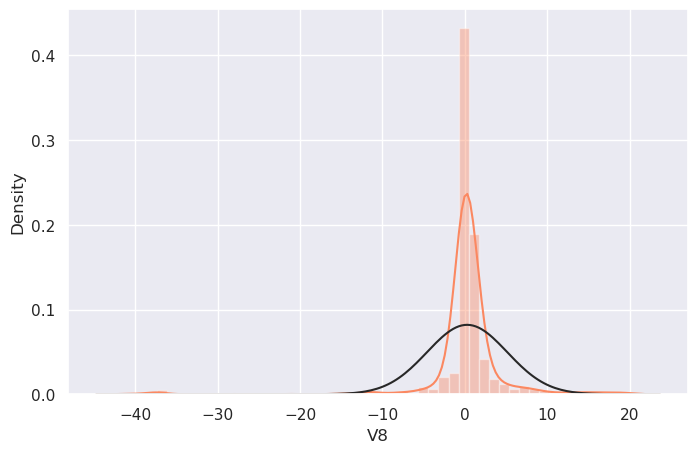

<Figure size 800x500 with 0 Axes>

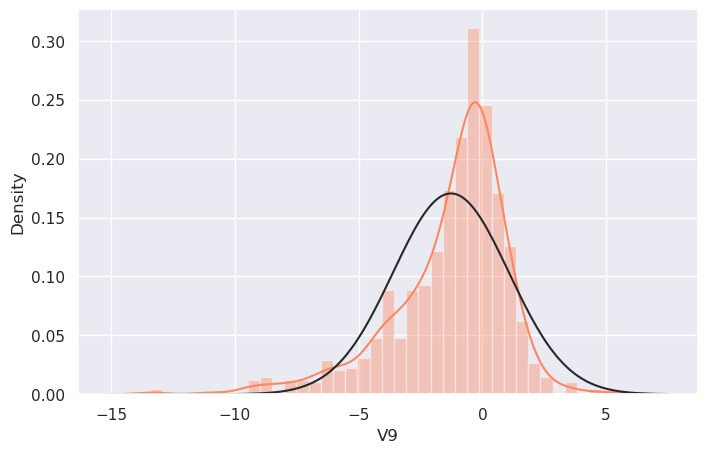

<Figure size 800x500 with 0 Axes>

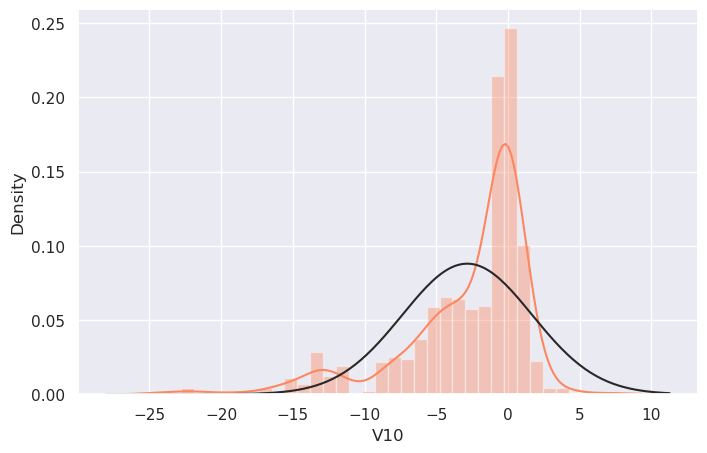

<Figure size 800x500 with 0 Axes>

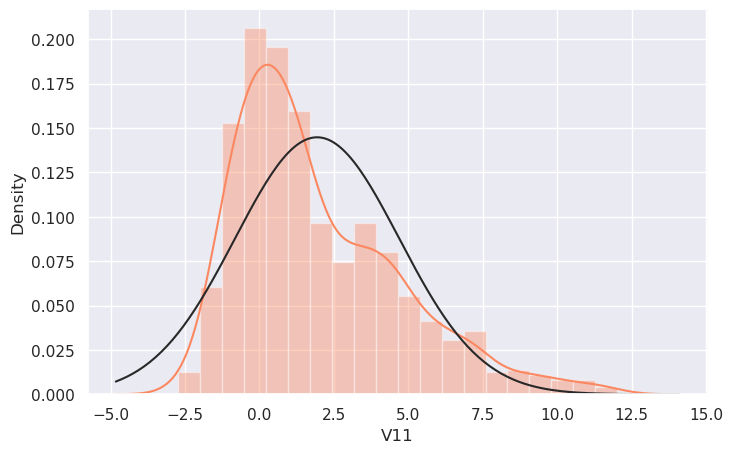

<Figure size 800x500 with 0 Axes>

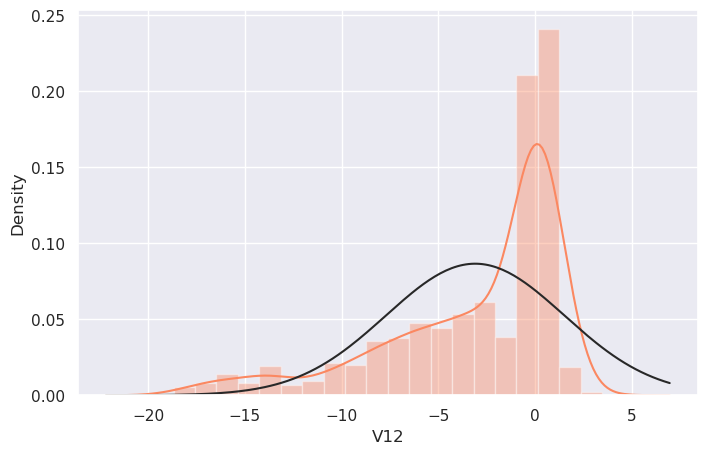

<Figure size 800x500 with 0 Axes>

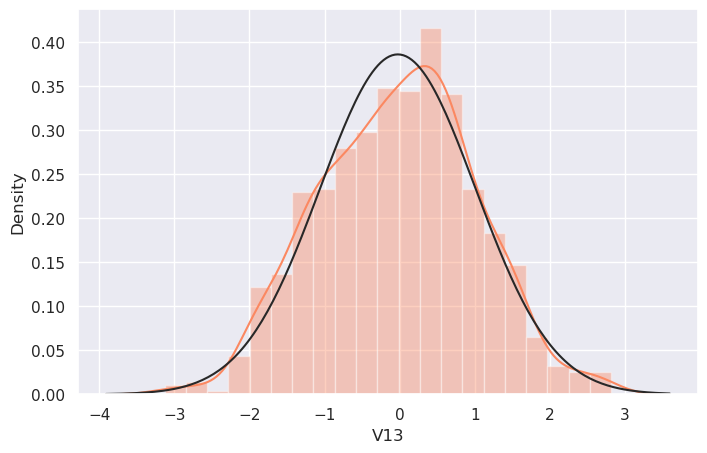

<Figure size 800x500 with 0 Axes>

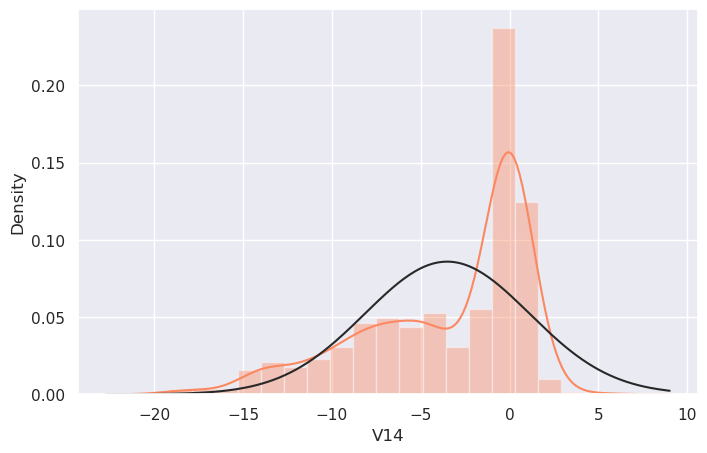

<Figure size 800x500 with 0 Axes>

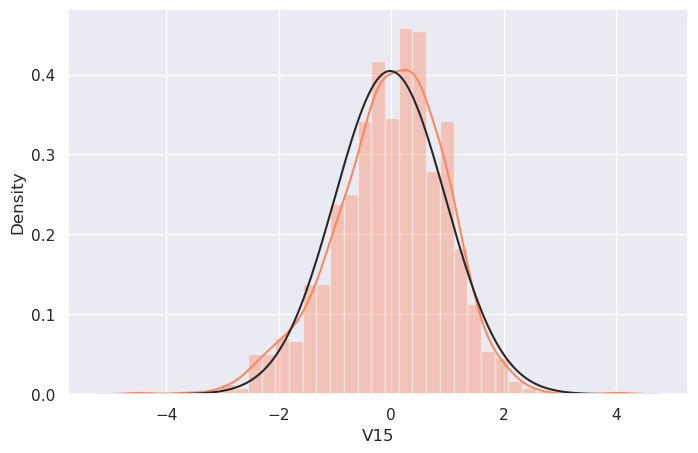

<Figure size 800x500 with 0 Axes>

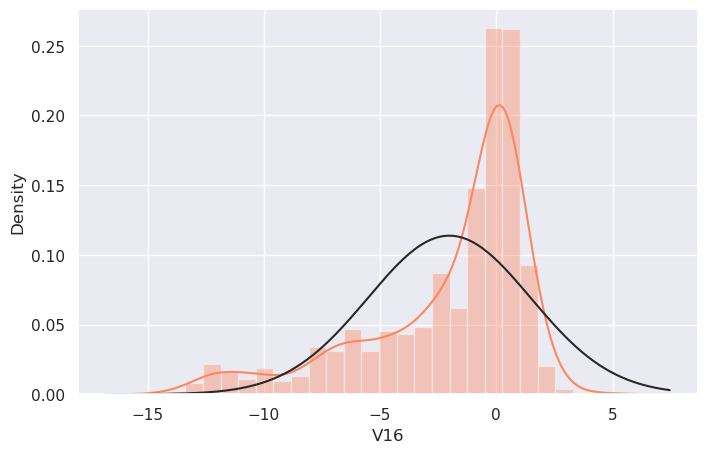

<Figure size 800x500 with 0 Axes>

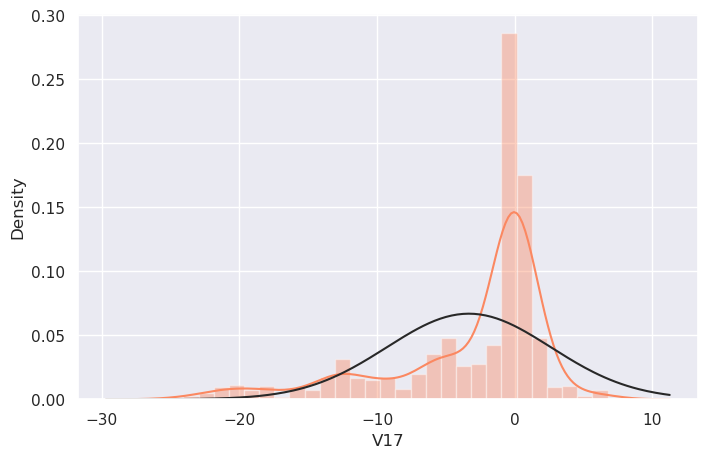

<Figure size 800x500 with 0 Axes>

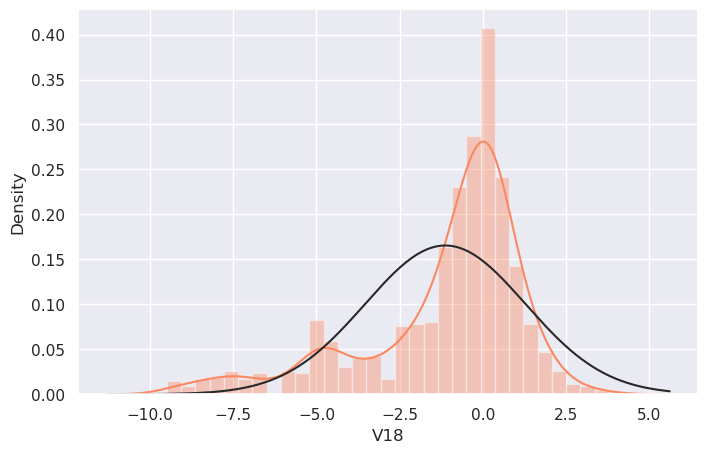

<Figure size 800x500 with 0 Axes>

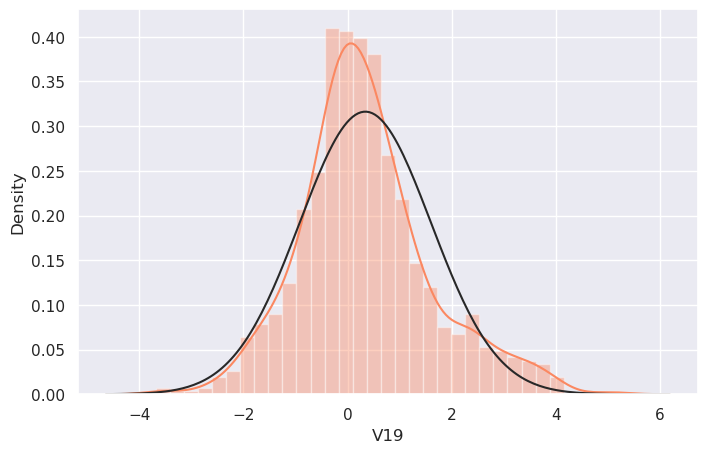

<Figure size 800x500 with 0 Axes>

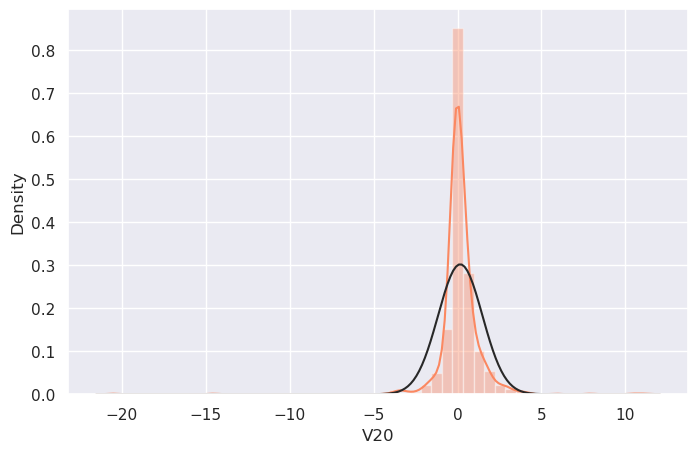

<Figure size 800x500 with 0 Axes>

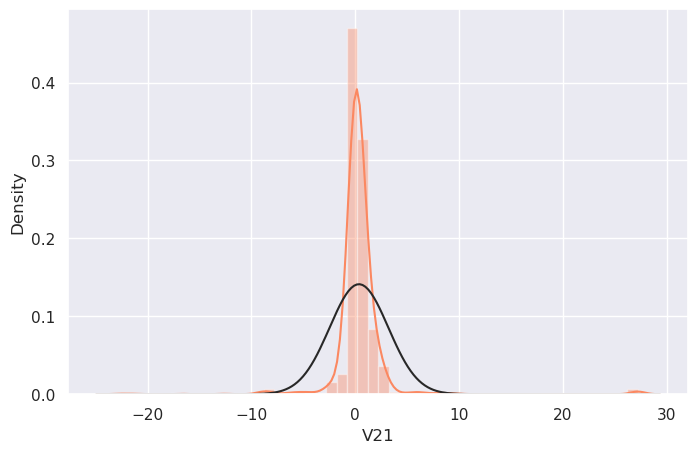

<Figure size 800x500 with 0 Axes>

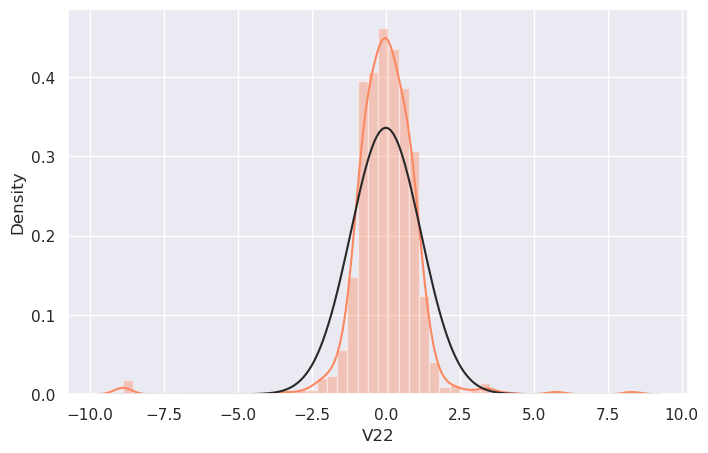

<Figure size 800x500 with 0 Axes>

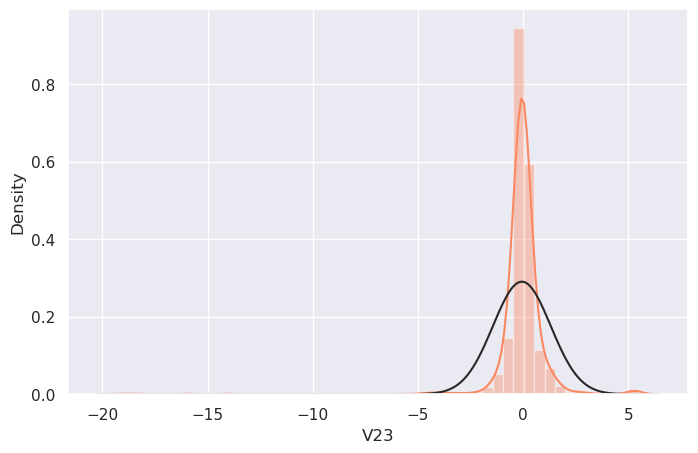

<Figure size 800x500 with 0 Axes>

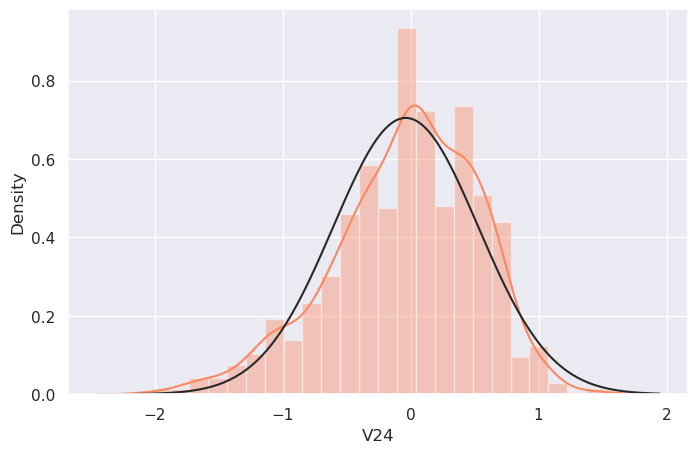

<Figure size 800x500 with 0 Axes>

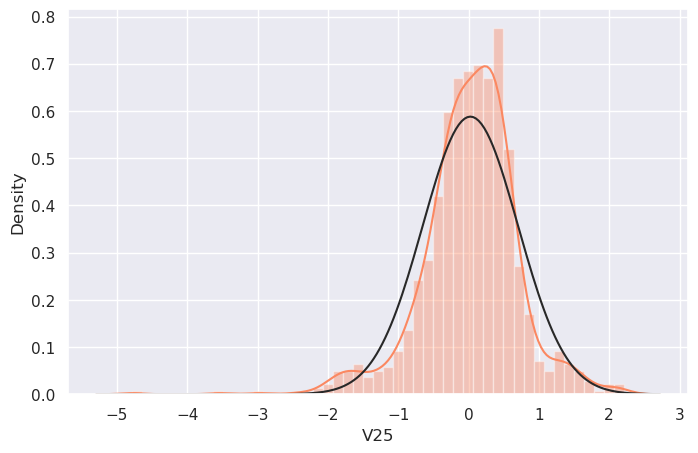

<Figure size 800x500 with 0 Axes>

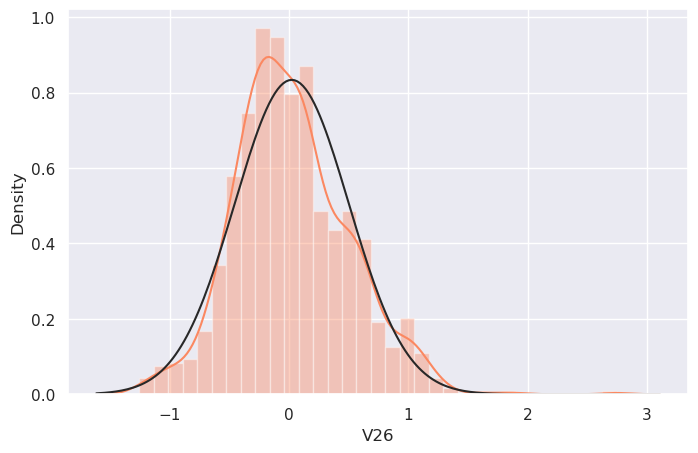

<Figure size 800x500 with 0 Axes>

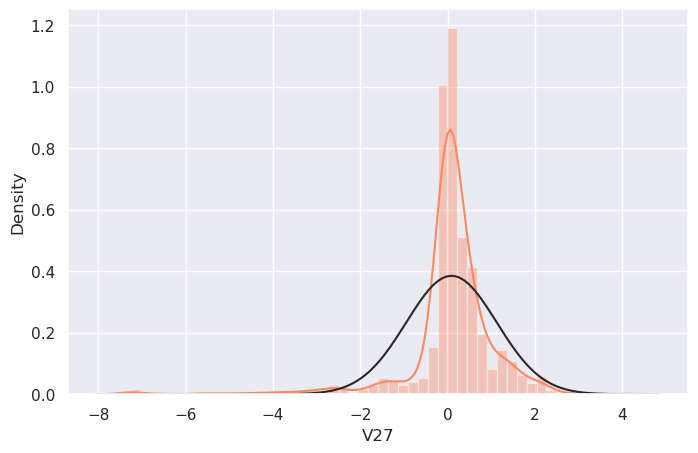

<Figure size 800x500 with 0 Axes>

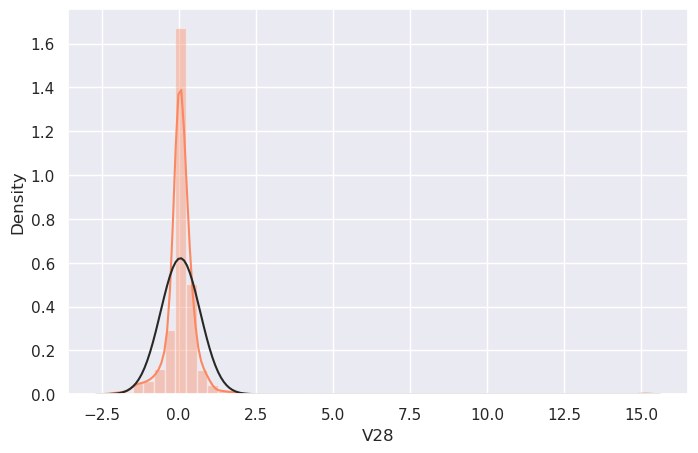

<Figure size 800x500 with 0 Axes>

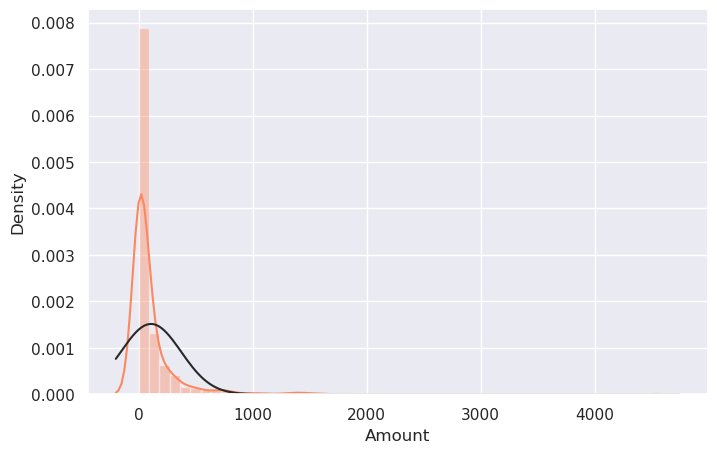

<Figure size 800x500 with 0 Axes>

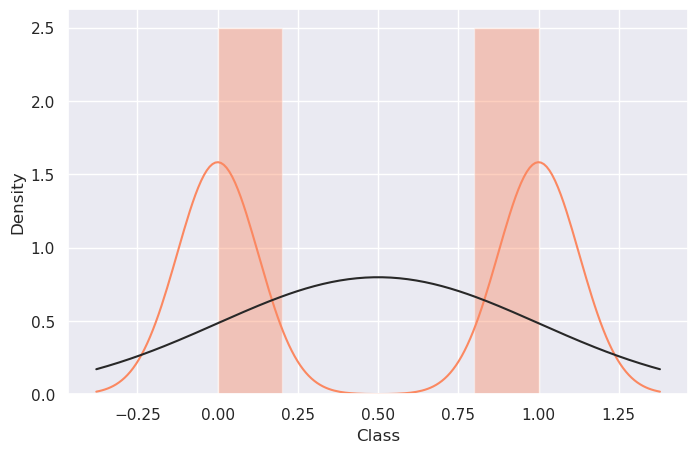

In [43]:
for i in new_df1.columns:
    plt.figure();
    plt.tight_layout()
    sns.set(rc={"figure.figsize":(8, 5)})
    f, (ax_hist) = plt.subplots(1, sharex=True)
    plt.gca().set(xlabel= i,ylabel='Density')
    #sns.histplot(new_df[i], ax=ax_hist ,  bins = 20, kde=True)
    sns.distplot(new_df1[i], ax=ax_hist, fit=norm, color='#FB8861')

#plt.show()

## Outliers

In [44]:
z = np.abs(stats.zscore(new_df1.loc[:, ~new_df1.columns.isin(['Time','Class'])]))
threshold = 3
df1_new = new_df1[(z < 3).all(axis=1)]

df1_new.describe().T 

count       mean         std        min       25%        50%  \
V1      850.0  -1.066015    3.018845 -17.275191 -1.927776  -0.504678   
V2      850.0   1.062553    2.169926  -8.402154 -0.211797   0.854078   
V3      850.0  -1.985315    3.819152 -21.872317 -3.741980  -0.872726   
V4      850.0   1.590192    2.698292  -4.414009 -0.337381   0.855537   
V5      850.0  -0.612406    2.410975 -13.565130 -1.191437  -0.255676   
V6      850.0  -0.579205    1.454475  -5.773192 -1.316558  -0.559177   
V7      850.0  -1.318497    3.006404 -15.893788 -1.941257  -0.454497   
V8      850.0   0.366870    1.859344 -12.108284 -0.188065   0.120423   
V9      850.0  -0.842525    1.731002  -7.718751 -1.695002  -0.533958   
V10     850.0  -1.862107    3.146880 -15.563791 -3.465240  -0.603120   
V11     850.0   1.442128    2.305563  -2.739626 -0.251105   0.878279   
V12     850.0  -2.199015    3.623878 -16.465504 -3.986416  -0.488093   
V13     850.0  -0.020184    1.014141  -2.740228 -0.776886  -0.003527   
V14     850.0  -2.827098    4.095220 -16.337596 -5.426489  -0.717930   
V15     850.0   0.016356    0.941718  -2.799076 -0.605995   0.133916   
V16     850.0  -1.311336    2.689080 -12.375397 -2.401893  -0.289429   
V17     850.0  -2.113442    4.508681 -21.090613 -3.352109  -0.375624   
V18     850.0  -0.623498    1.809177  -7.990783 -1.191775  -0.167527   
V19     850.0   0.225133    1.159721  -3.286150 -0.440167   0.136285   
V20     850.0   0.091138    0.633791  -2.806302 -0.172744  -0.002134   
V21     850.0   0.281088    0.991304  -5.688990 -0.152895   0.119692   
V22     850.0   0.023309    0.744689  -3.305644 -0.540076  -0.007726   
V23     850.0   0.000609    0.482005  -4.129195 -0.202171  -0.037802   
V24     850.0  -0.044648    0.540617  -1.711993 -0.373432  -0.004201   
V25     850.0   0.042773    0.567281  -1.959304 -0.284636   0.083292   
V26     850.0   0.016777    0.461237  -1.253686 -0.298241  -0.028784   
V27     850.0   0.112006    0.582655  -2.693036 -0.043835   0.043431   
V28     850.0   0.055895    0.348027  -1.869290 -0.047512   0.031834   
Amount  850.0  84.841659  145.810191   0.000000  1.645000  19.020000   
Class   850.0   0.437647    0.496389   0.000000  0.000000   0.000000   

              75%         max  
V1       1.140375    2.323610  
V2       2.031914   10.819665  
V3       0.609010    3.544061  
V4       3.370195   11.927512  
V5       0.596530    9.880564  
V6       0.051119    4.411550  
V7       0.359167    5.802537  
V8       0.717058   11.580797  
V9       0.258872    4.478738  
V10      0.072271    7.844096  
V11      2.773685   10.187587  
V12      0.358589    3.466089  
V13      0.665026    2.815440  
V14      0.140967    3.730320  
V15      0.677798    2.471358  
V16      0.403397    3.139656  
V17      0.322585    6.739384  
V18      0.390056    3.790316  
V19      0.795838    3.856375  
V20      0.326556    3.792667  
V21      0.535600    8.664662  
V22      0.572605    2.941475  
V23      0.165039    2.883903  
V24      0.365819    1.335047  
V25      0.407322    1.605056  
V26      0.286161    1.325311  
V27      0.365026    2.300164  
V28      0.186235    1.890235  
Amount  99.990000  829.410000  
Class    1.000000    1.000000

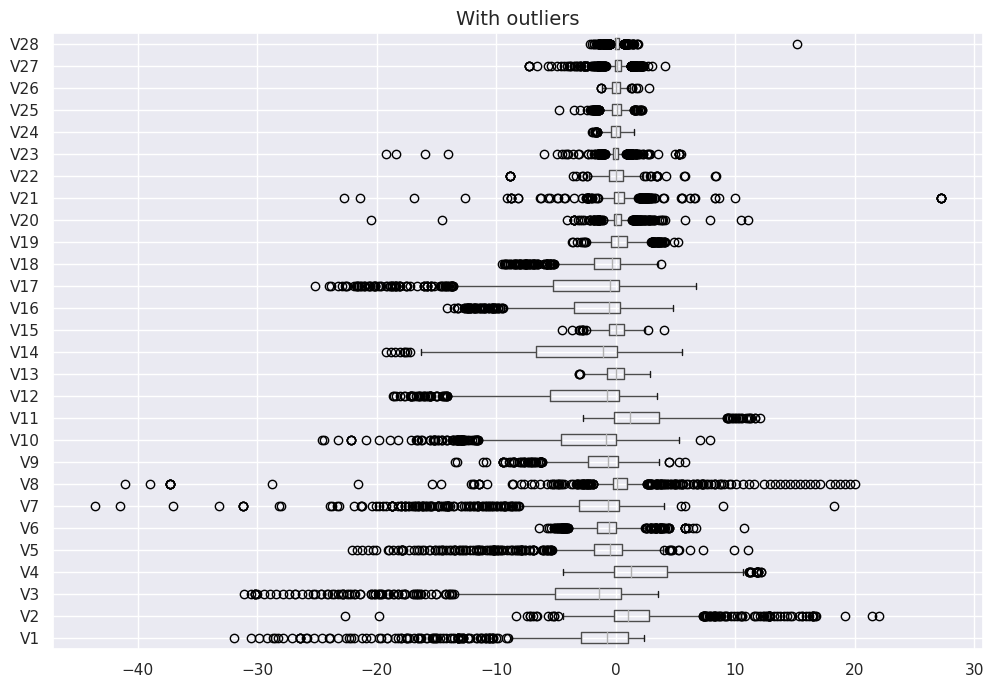

In [45]:
new_df1.loc[:, ~new_df1.columns.isin(['Amount','Time','Class', 'IsFraud','time_udf'])].boxplot( figsize=(12,8), vert=False)
plt.title("With outliers", fontsize=14)
plt.show()

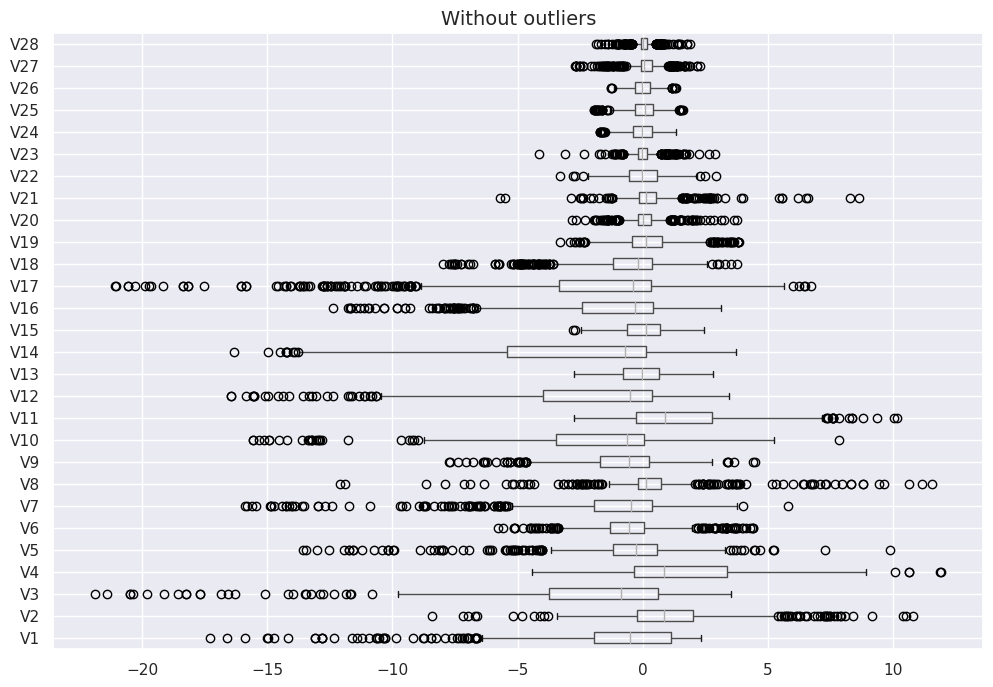

In [46]:
df1_new.loc[:, ~df1_new.columns.isin(['Amount','Time','Class'])].boxplot( figsize=(12,8), vert=False)
plt.title("Without outliers", fontsize=14)
plt.show()

In [47]:
# % of data removed :
print("percentage of records removed is :",(1 - (df1_new.shape[0] / new_df1.shape[0]))*100,", it is an accepted % ")

percentage of records removed is : 13.617886178861793 , it is an accepted % 


In [48]:
#Plot Distribution of the Classes
print('Distribution of the Classes in the dataset without outliers')
print(df1_new['Class'].value_counts()/len(df1_new))

sns.countplot(x ='Class', data=df1_new)
plt.title('Balanced Classes without outliers', fontsize=14)
plt.show()

Distribution of the Classes in the dataset without outliers
0    0.562353
1    0.437647
Name: Class, dtype: float64


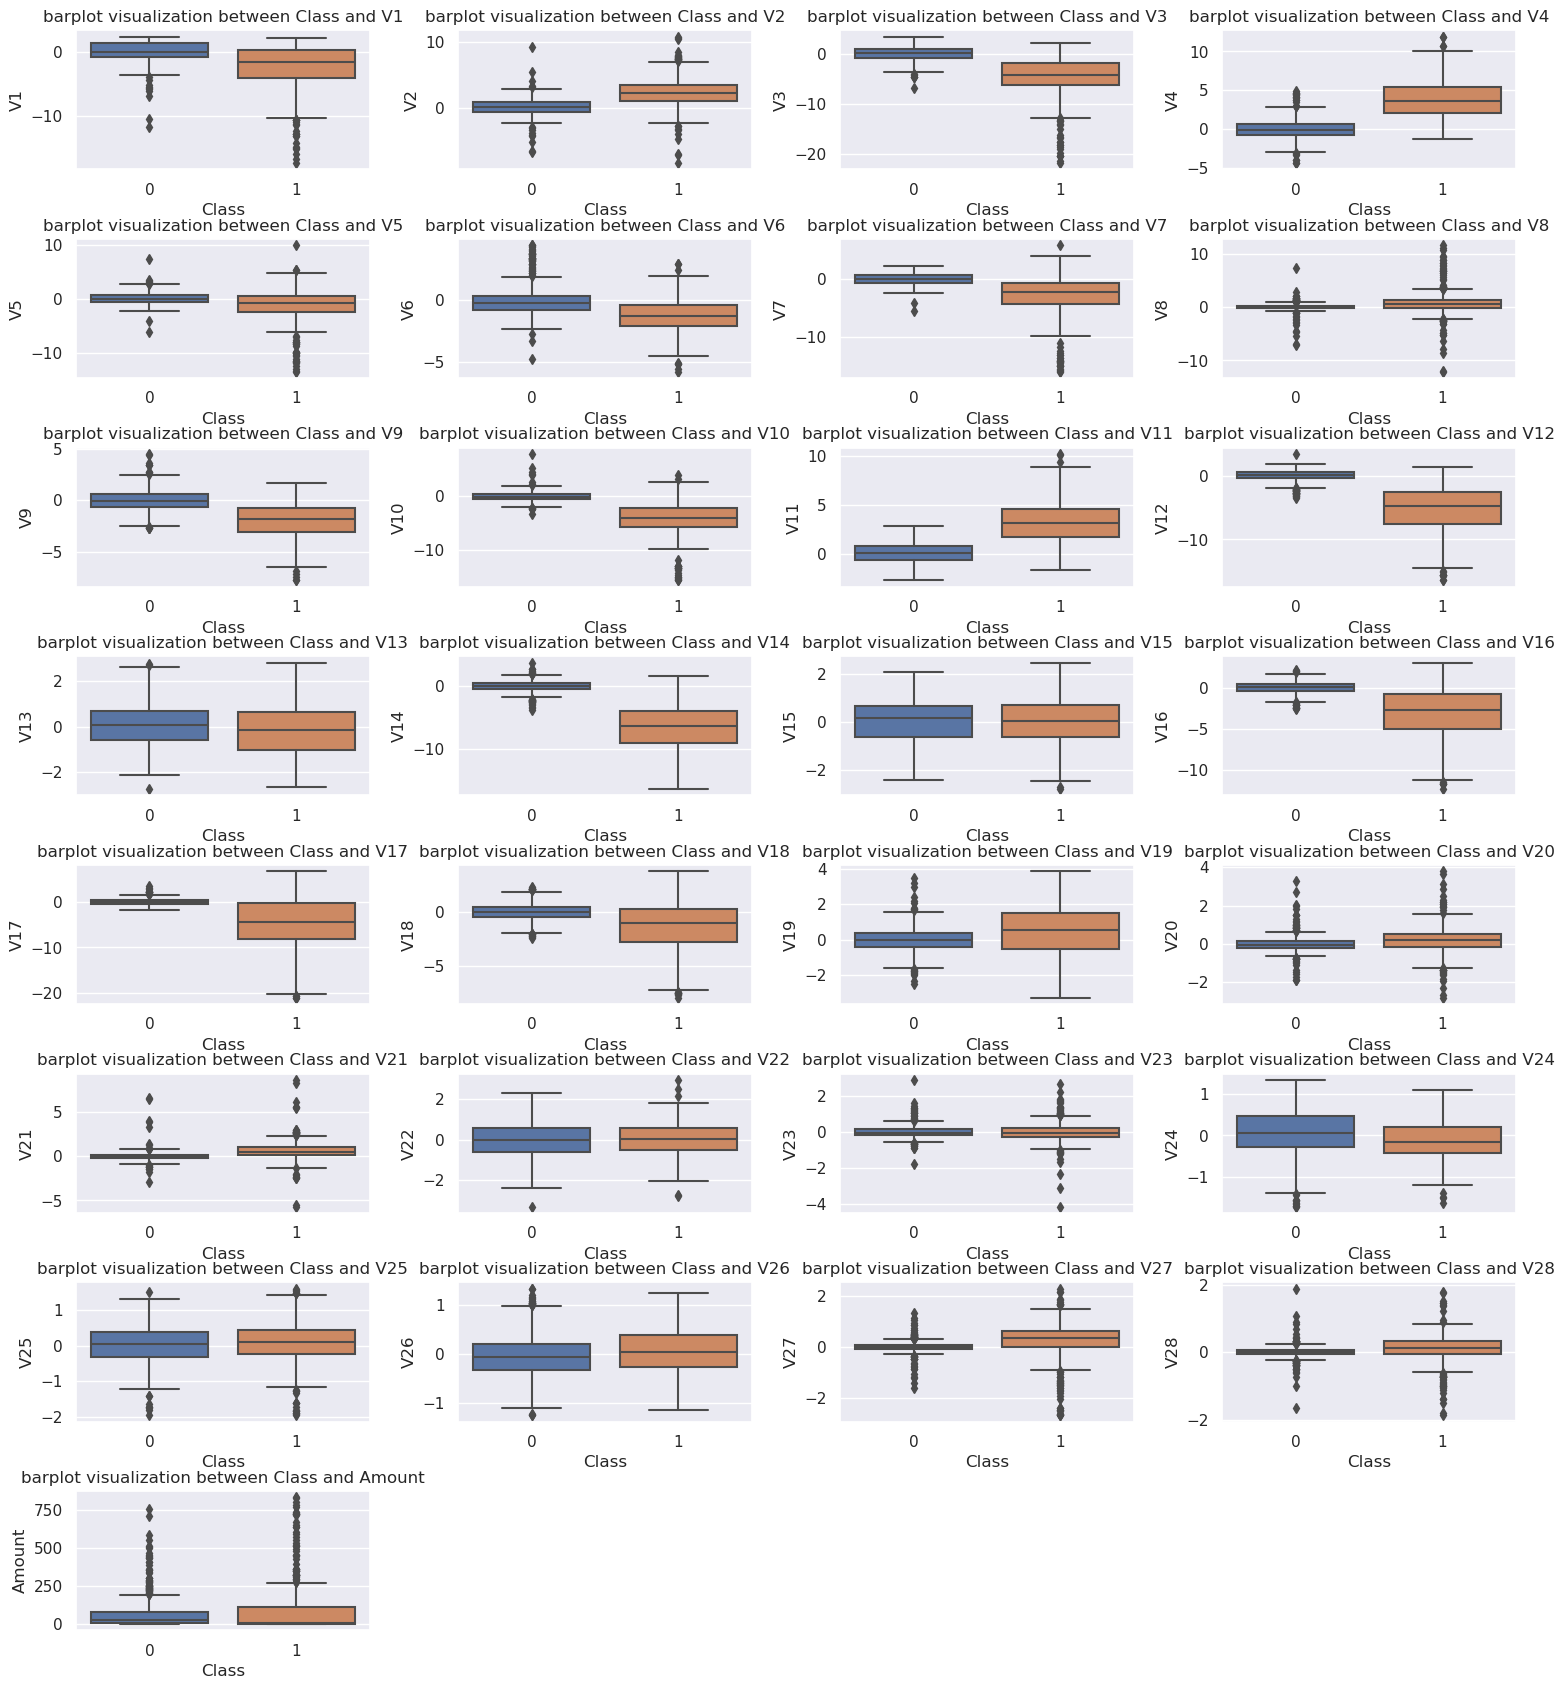

In [49]:
# Visualization of the relation between each variable and Class in a balanced dataset without outliers
x = 0
plt.figure(figsize = [18,20]);
for i in df1_new.loc[:, ~df1_new.columns.isin(['Time','Class'])] :
    plt.subplot(8,4,x+1)
    sns.boxplot(data = df1_new, x = 'Class', y = i)
    plt.title("barplot visualization between Class and {}".format(i), size = 12);
    x = x +1
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.3,  
                    hspace=0.5) 
plt.show()

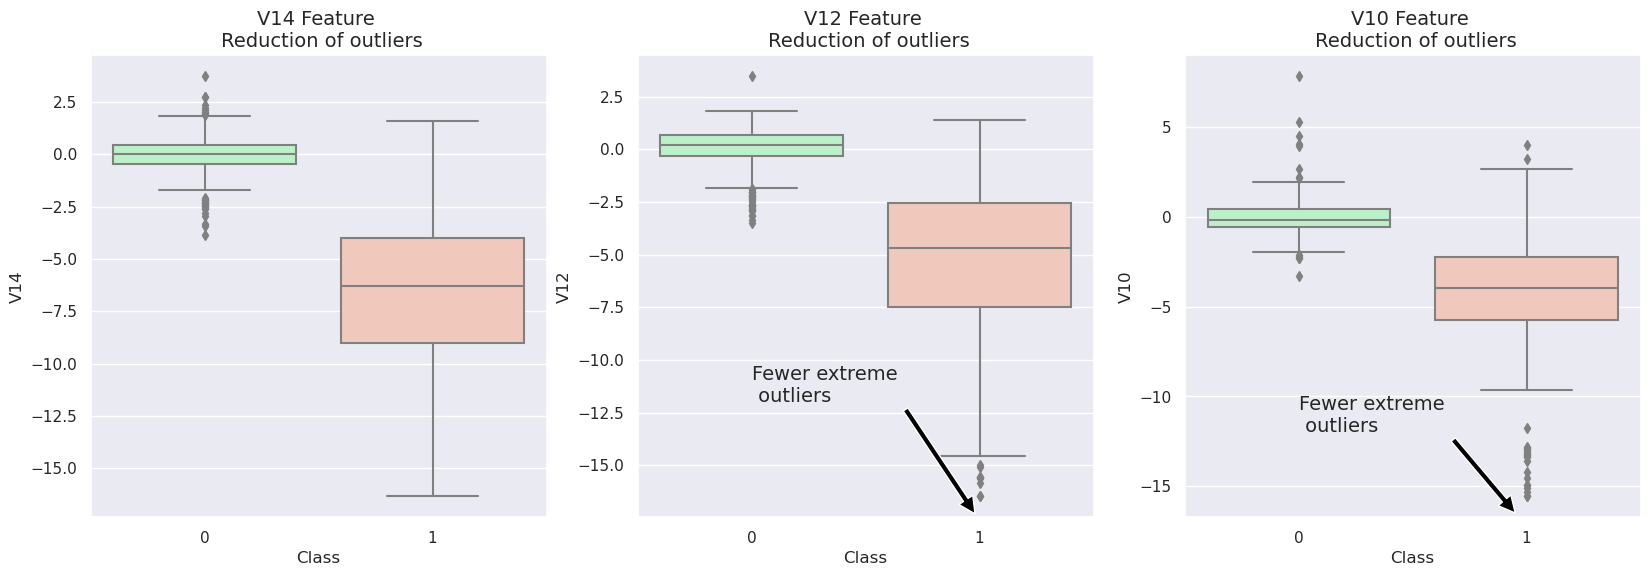

In [50]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=df1_new,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
             arrowprops=dict(facecolor='black'),
             fontsize=14)
# Feature 12
sns.boxplot(x="Class", y="V12", data=df1_new, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
             arrowprops=dict(facecolor='black'),
             fontsize=14)
# Feature V10
sns.boxplot(x="Class", y="V10", data=df1_new, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
             arrowprops=dict(facecolor='black'),
             fontsize=14)
plt.show()

## Features Selection

In [91]:
# df1_new dataset to be used
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

df1_new.head()

V1        V2        V3        V4        V5        V6        V7  \
60887   1.356904 -1.243658  0.850109 -1.345224 -1.893804 -0.592204 -1.260592   
201098  1.176633  3.141918 -6.140445  5.521821  1.768515 -1.727186 -0.932429   
179010 -0.100222 -0.749391  1.715381 -2.559824 -1.124932 -0.579363 -0.226621   
88897  -5.267760  2.506719 -5.290925  4.886134 -3.343188 -1.100085 -5.810509   
215984 -4.861747 -2.722660 -4.656248  2.502005 -2.008346  0.615422 -3.485680   

              V8        V9       V10  ...       V21       V22       V23  \
60887  -0.043386 -1.921551  1.572882  ...  0.077649  0.521465 -0.062921   
201098  0.292797 -3.156827 -3.898240  ...  0.129372 -0.803021 -0.074098   
179010 -0.167495 -1.489149  0.906442  ... -0.398828 -0.737619  0.086896   
88897   1.726343 -0.749277 -4.834828  ...  0.764266  0.473262  0.548482   
215984  1.878856 -1.116268 -5.112971  ...  1.138876  1.033664 -0.806199   

             V24       V25       V26       V27       V28  Amount  Class  
60887   0.545105  0.324808 -0.089897  0.040216  0.026094   57.20      0  
201098 -0.031084  0.375366  0.065897  0.488258  0.325872    0.00      1  
179010 -0.152247 -0.599184 -0.503089 -0.029067 -0.077645   39.95      0  
88897  -0.156850 -0.710187 -0.366423 -1.486766  0.677664    1.10      1  
215984 -1.511046 -0.191731  0.080999  1.215152 -0.923142  592.90      1  

[5 rows x 30 columns]

## Correlation Coefficient Method

Correlation is a measure of the linear relationship between 2 or more variables. Through correlation, we can predict one variable from the other. The logic behind using correlation for feature selection is that good variables correlate highly with the target. Furthermore, variables should be correlated with the target but uncorrelated among themselves.

If two variables are correlated, we can predict one from the other. Therefore, if two features are correlated, the model only needs one, as the second does not add additional information. We will use the Pearson Correlation here.

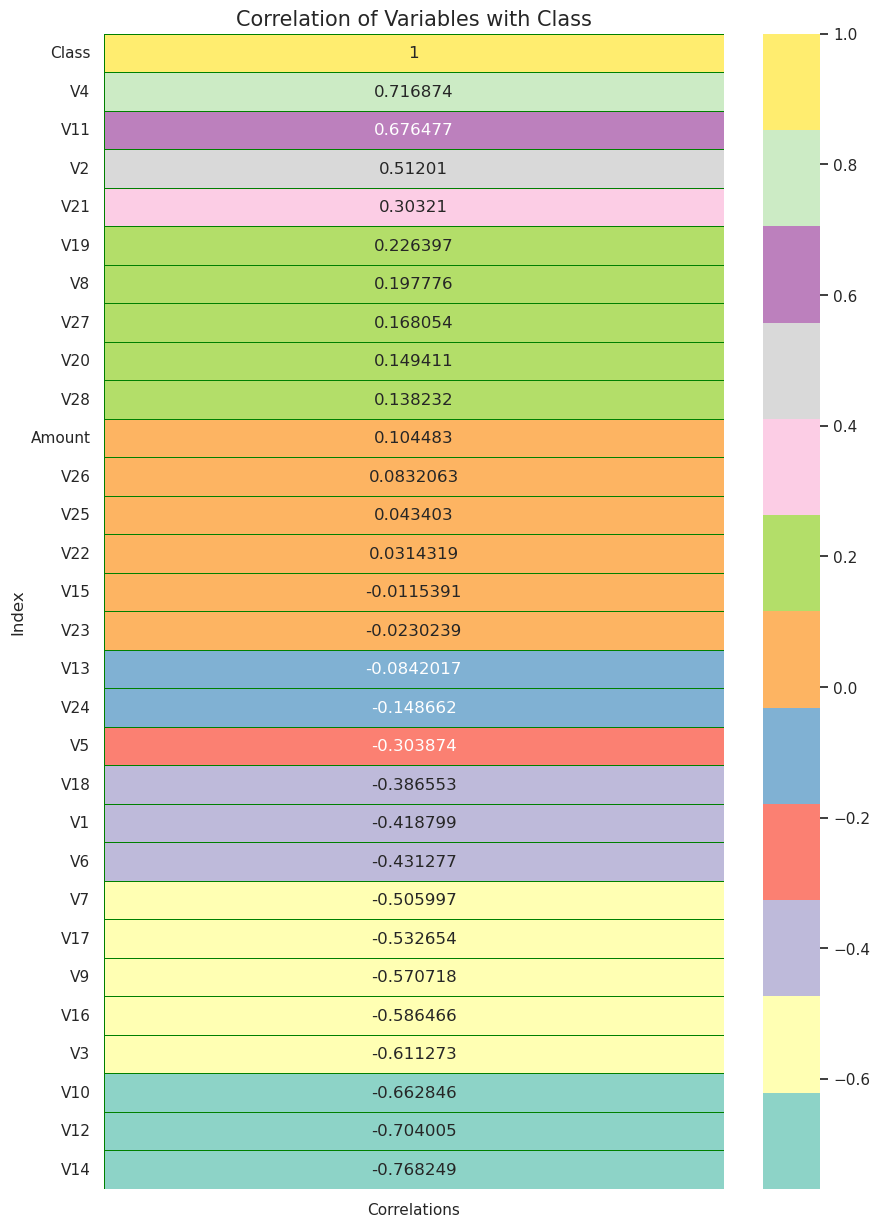

In [191]:

corr = df1_new.corrwith(df1_new['Class'],method='pearson').reset_index()

corr.columns = ['Index','Correlations']
corr = corr.set_index('Index')
corr = corr.sort_values(by=['Correlations'], ascending = False).head(30)

plt.figure(figsize=(10, 15))
fig = sns.heatmap(corr, annot=True, fmt="g", cmap='Set3', linewidths=0.4, linecolor='green')

plt.title("Correlation of Variables with Class", fontsize=15)
plt.show()

##  Kbest Select Method

Select features according to the k highest scores.

In [117]:
X = df1_new.drop(['Class'],axis = 1)
target = df1_new['Class']
target_train, X_test, Y_train, Y_test = train_test_split(X, target, test_size= 0.3, random_state = 42)

In [169]:
from sklearn.feature_selection import SelectKBest
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=29)
fit = bestfeatures.fit(X,target)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns) 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(23,'Score'))  


   Feature     Score
13     V14  0.458592
16     V17  0.424814
9      V10  0.419535
11     V12  0.379724
3       V4  0.366917
10     V11  0.351390
15     V16  0.309990
2       V3  0.308177
6       V7  0.287282
1       V2  0.252486
20     V21  0.216832
8       V9  0.216382
26     V27  0.194574
17     V18  0.168212
27     V28  0.167706
5       V6  0.161192
0       V1  0.160836
28  Amount  0.140227
18     V19  0.121997
4       V5  0.119648
7       V8  0.096004
19     V20  0.062673
23     V24  0.043172


<BarContainer object of 29 artists>

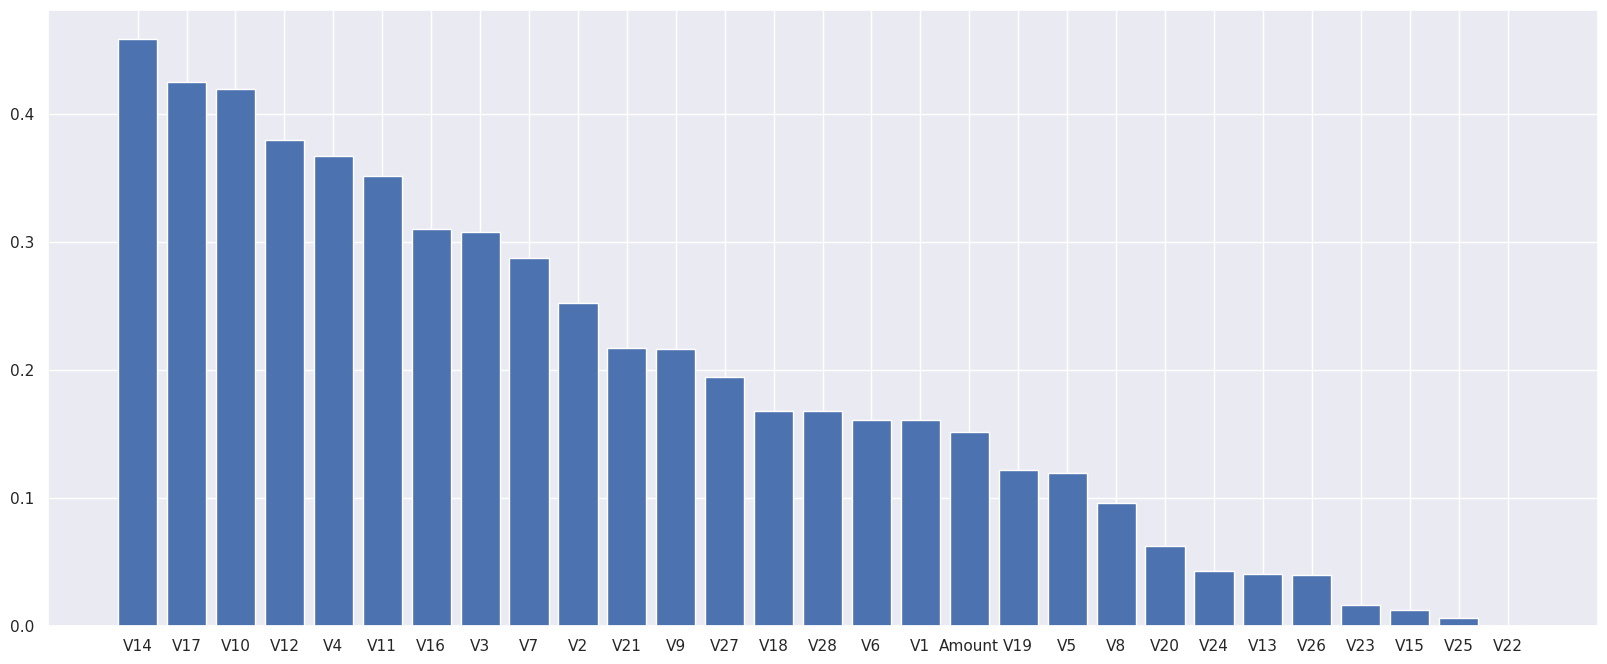

In [144]:
plt.figure(figsize=(20,8))
featureScores2 = featureScores.sort_values('Score', ascending=False)
plt.bar("Feature", "Score", data=featureScores2)


## Mutual Information Classification Method

Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

In [168]:
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X_train, Y_train)
mutual_info = pd.Series(mutual_info)
dfcolumns = pd.DataFrame(X.columns) 
feature_score3 = pd.concat([dfcolumns,mutual_info],axis=1)
feature_score3.columns = ['Feature','Score'] 
print(feature_score3.nlargest(28,'Score'))  


   Feature     Score
13     V14  0.465868
9      V10  0.430229
16     V17  0.426665
11     V12  0.392423
3       V4  0.364998
10     V11  0.327878
6       V7  0.312531
15     V16  0.302870
2       V3  0.282922
1       V2  0.257177
8       V9  0.234202
26     V27  0.214625
20     V21  0.188344
17     V18  0.175506
5       V6  0.170273
27     V28  0.163657
0       V1  0.155152
28  Amount  0.149985
18     V19  0.109523
4       V5  0.105425
7       V8  0.090182
19     V20  0.067851
25     V26  0.030742
12     V13  0.025659
14     V15  0.020102
23     V24  0.019007
21     V22  0.008713
22     V23  0.007597


<BarContainer object of 29 artists>

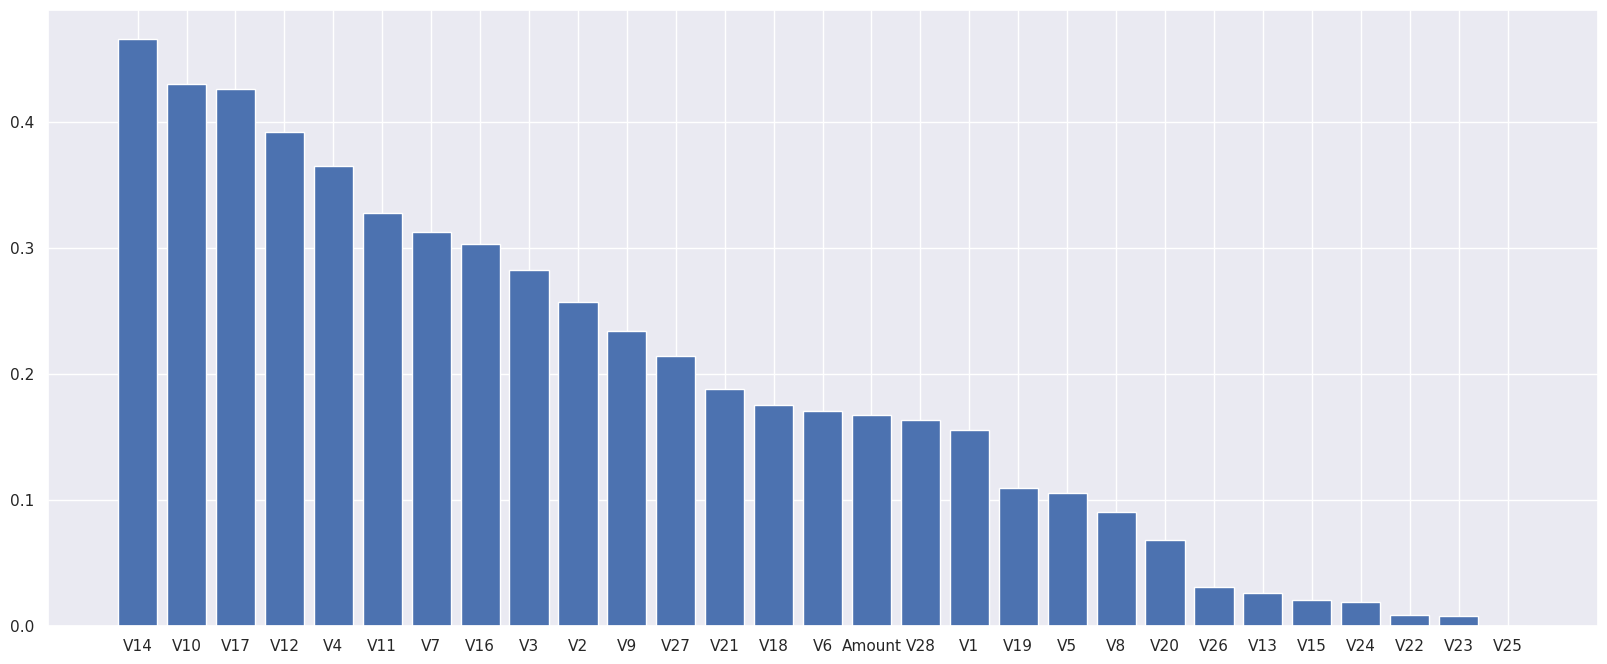

In [167]:
plt.figure(figsize=(20,8))
feature_score4 = feature_score3.sort_values('Score', ascending=False)
plt.bar("Feature", "Score", data=feature_score4)


## Observations:

Based on our analysis, we can conclude that features V14, V10, V17, V12, and V4 have a higher potential to explain whether a fraud may occur or not. These variables could play a crucial role in identifying potential fraud and help prevent it. However, in correlation method has a correlation value V17 smaller than for example V11, V3, V16 and V9.

_______________________________________________________________________________________

## Machine Learning - É PRECISO REVER TUDO DAQUI PARA BAIXO

In [51]:
# Importing required Spark ML lib methods

from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import DenseVector

In [52]:
dfsp = spark.createDataFrame(new_df.loc[:, ~new_df.columns.isin(['IsFraud','time_udf'])])


In [53]:
# Converting String data type of column to double

for column in dfsp.columns:
    data = dfsp.withColumn(column,dfsp[column].cast("double"))

In [54]:
#Adding index to keep track of the rows even after shuffling

from pyspark.sql.functions import *
from pyspark.sql.window import Window
win = Window().orderBy('Time')
dfsp = dfsp.withColumn("idx", row_number().over(win))

In [55]:
dfsp.head()

Row(Time=242.0, V1=-0.398935074654529, V2=0.94195326776366, V3=1.35928845303101, V4=0.0134901030401388, V5=-0.191939978339293, V6=-0.824440908996528, V7=0.474948313294724, V8=0.175556956003134, V9=-0.362986724172781, V10=-0.283273787518482, V11=1.32520174943218, V12=-0.396477303619385, V13=-2.02068997157013, V14=0.181072418856814, V15=0.399853328919428, V16=0.614077430749912, V17=-0.0528833993886769, V18=0.537637279684669, V19=0.135445718311091, V20=-0.0122579089945038, V21=-0.222209702306461, V22=-0.704461341026704, V23=0.0208067621812623, V24=0.429138402387884, V25=-0.28639685072835, V26=0.0485793849574308, V27=0.229095605842275, V28=0.0858022387553144, Amount=2.69, Class=0, idx=1)

In [56]:
feature_columns = [col for col in dfsp.columns if col.startswith("V")]
print(feature_columns)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']


In [57]:
vectorizer = VectorAssembler(inputCols = feature_columns, outputCol="features")
vectorizer.transform(df).select("features", "Class").limit(5).toPandas()

features  Class
0  [-1.3598071336738, -0.0727811733098497, 2.5363...      0
1  [1.19185711131486, 0.26615071205963, 0.1664801...      0
2  [-1.35835406159823, -1.34016307473609, 1.77320...      0
3  [-0.966271711572087, -0.185226008082898, 1.792...      0
4  [-1.15823309349523, 0.877736754848451, 1.54871...      0

In [58]:
est = RandomForestClassifier()
est.setMaxDepth(5)
est.setLabelCol("Class")

RandomForestClassifier_eacaf4e0580f

In [59]:
print(est.explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

In [60]:
# Importing required Spark ML lib methods

from pyspark.ml.pipeline import Pipeline, PipelineModel
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import DenseVector

In [61]:
# Converting the feature columns to dense vector (required by spark) and creating label and index columns

training_df = dfsp.rdd.map(lambda x: (DenseVector(x[0:29]),x[30],x[31]))

In [62]:
training_df = spark.createDataFrame(training_df,["features","label","index"])

In [63]:
training_df = training_df.select("index","features","label")

In [64]:
# Splitting data into training and testing data

train_data, test_data = training_df.randomSplit([.8,.2],seed=1234)

In [65]:
train_data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  388|
|    1|  394|
+-----+-----+



In [66]:
test_data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  104|
|    1|   98|
+-----+-----+



In [67]:
df_train, df_test = df.randomSplit(weights=[0.7, 0.3], seed = 1)

In [68]:
pipeline = Pipeline()
pipeline.setStages([vectorizer, est])
model = pipeline.fit(df_train)

In [69]:

df_test_pred = model.transform(df_test)

In [70]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [71]:
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol("Class")

BinaryClassificationEvaluator_7a2ecf2524bf

In [72]:
evaluator.evaluate(model.transform(df_test))

0.9637342698273338

In [73]:
from pyspark.sql.functions import *

In [74]:
test_accuracy = (df_test_pred
                 .select("Class", "prediction")
                 .withColumn("isEqual", expr("Class == prediction"))
                 .select(avg(expr("cast(isEqual as float)")))
                 .first())

In [75]:
test_accuracy

Row(avg(CAST(isEqual AS FLOAT))=0.9994389442801538)

In [76]:
treeEstimator = DecisionTreeClassifier()
treeEstimator.setImpurity("entropy")
treeEstimator.setLabelCol("Class")

pipeline = Pipeline()
pipeline.setStages([vectorizer, treeEstimator])
model = pipeline.fit(df_train)
evaluator.evaluate(model.transform(df_test))

0.8001921458882059

In [77]:
accuracy_evaluator = MulticlassClassificationEvaluator()
accuracy_evaluator.setLabelCol("Class")
accuracy_evaluator.setMetricName("accuracy")
accuracy_evaluator.evaluate(model.transform(df_test))

0.999368812315173

In [78]:
f1_evaluator = MulticlassClassificationEvaluator()
f1_evaluator.setLabelCol("Class")
f1_evaluator.setMetricName("f1")
f1_evaluator.evaluate(model.transform(df_test))

0.9993533134713535

## Gradient Boosting Trees Classifier Model

In [79]:
# Creating Gradient Boosting Trees Classifier Model to fit and predict data

gbt = GBTClassifier(featuresCol="features", maxIter=100,maxDepth=8)
model = gbt.fit(train_data)
predictions = model.transform(test_data)

In [80]:
# Checking the count of records classified into each classes

predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|   99|
|       1.0|  103|
+----------+-----+



In [81]:
# Calculating accuracy of model

evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.9694858712715854

In [82]:
# Calculating percentage of fraud records predicted correctly

predictions = predictions.withColumn("fraudPrediction",when((predictions.label==1)&(predictions.prediction==1),1).otherwise(0))
predictions.groupBy("fraudPrediction").count().show()

+---------------+-----+
|fraudPrediction|count|
+---------------+-----+
|              1|   91|
|              0|  111|
+---------------+-----+



In [83]:
predictions.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  104|
|    1|   98|
+-----+-----+



In [84]:
accurateFraud = predictions.groupBy("fraudPrediction").count().where(predictions.fraudPrediction==1).head()[1]
totalFraud = predictions.groupBy("label").count().where(predictions.label==1).head()[1]
FraudPredictionAccuracy = (accurateFraud/totalFraud)*100
print("Fraud Prediction Accuracy: ",FraudPredictionAccuracy)

Fraud Prediction Accuracy:  92.85714285714286


In [85]:
# Calculating Confusion matrix

tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()
tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()
fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()
fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()
print("True Positive: ",tp,"\nTrue Negative: ",tn,"\nFalse Positive: ",fp,"\nFalse Negative: ",fn)
print("Recall: ",tp/(tp+fn))
print("Precision: ", tp/(tp+fp))
print("F1 Score",  (2 * (tp/(tp+fp)) * (tp/(tp+fn)) /((tp/(tp+fp)) + (tp/(tp+fn)))))

True Positive:  91 
True Negative:  92 
False Positive:  12 
False Negative:  7
Recall:  0.9285714285714286
Precision:  0.883495145631068
F1 Score 0.9054726368159205
